# Projet 7 : Réalisez une analyse de sentiment grâce au Deep Learning

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Importation des librairies](#partie2.1)
    * [2.2 Répertoire des fonctions](#partie2.2)
    * [2.3 Chargement du jeu de données](#partie2.3)
* [3. EDA](#partie3)
    * [3.1 Exploration Initiale](#partie3.1)
    * [3.2 Nettoyage du dataframe](#partie3.2)
* [4. Prétraitement des données](#partie4)
    * [4.1 Nettoyage des données](#partie4.1)
    * [4.2 BoW et TF-IDF](#partie4.2)
* [5. Modélisation Simple](#partie5)
* [6. Modélisation Avancée](#partie6)
    * [6.1 Word Embedding](#partie6.1)
    * [6.2 Modélisation](#partie6.2)
* [7. Modèle BERT](#partie7)
    * [7.1 Première approche](#partie7.1)
    * [7.2 Deuxième approche](#partie7.2)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Dans le cadre de mes missions en tant qu’ingénieur IA chez Marketing Intelligence Consulting (MIC), je suis chargé de développer un prototype d’intelligence artificielle pour la compagnie aérienne Air Paradis. Cette compagnie, soucieuse de son image sur les réseaux sociaux, fait face à des risques récurrents de « bad buzz », pouvant nuire à sa réputation et à la satisfaction de ses clients.

L’objectif de ce projet est de créer un produit IA capable d’anticiper ces bad buzz en analysant les tweets des utilisateurs et en prédisant leur tonalité (négative ou non). Air Paradis souhaite obtenir un modèle fonctionnel capable de classifier en temps réel le sentiment des tweets, via une API déployée sur le Cloud. Ce produit doit ainsi permettre à la compagnie de réagir rapidement face à des publications négatives, limitant ainsi leur propagation.

De plus, ce projet s’inscrit dans une démarche plus large d’exploration de différentes approches de modélisation, notamment :

- Modèle sur mesure simple : un modèle classique pour prédire le sentiment.
- Modèle sur mesure avancé : un modèle de réseau de neurones avec l’utilisation de word embeddings.
- Modèle avancé BERT : une approche plus complexe utilisant un modèle BERT fine-tuné sur les tweets.

L’implémentation de ces modèles s’accompagne d’une démarche rigoureuse de MLOps afin d’assurer la gestion, le suivi et la mise en production du modèle dans les meilleures conditions. Le projet intègre notamment l’utilisation de MLFlow pour le tracking des expérimentations, ainsi que l’automatisation du déploiement via des pipelines CI/CD sur des plateformes Cloud gratuites comme Azure ou Heroku.

Ce projet, bien que centré sur Air Paradis, a également pour ambition d’être généralisé à d’autres secteurs ou entreprises souhaitant maîtriser leur image en ligne.

## <font color='red'>2. Préparation de l'environnement </font><a class="anchor" id="partie2"></a>

### Installation librairies

In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [2]:
!pip install pyngrok

In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.1 MB/s eta 0:00:00


### <font color='blue'>2.1 Importation des librairies / Préparation MLFlow</font><a class="anchor" id="partie2.1">

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
import subprocess
from pyngrok import ngrok
import mlflow
import nltk
import torch
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers.legacy import Adam
from collections import Counter
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset

In [5]:
# Démarrer le serveur MLFlow en arrière-plan
mlflow_server = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

In [6]:
!ngrok config add-authtoken 2o7fRSSTsKkRHY1jl4VoX9qS7AR_5TCYPvixQ8rv7g5PqJp8t

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [7]:
ngrok.kill()

In [8]:
# Créer un tunnel pour le port 5000
public_url = ngrok.connect(5000)
print("MLFlow Tracking UI:", public_url)

MLFlow Tracking UI: NgrokTunnel: "https://6955-34-90-93-69.ngrok-free.app" -> "http://localhost:5000"


In [9]:
# Définir l'expérience
mlflow.set_experiment("Analyse de Sentiment des Tweets - Projet 7")

2024/11/20 15:22:15 INFO mlflow.tracking.fluent: Experiment with name 'Analyse de Sentiment des Tweets - Projet 7' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/298147219340770052', creation_time=1732116135861, experiment_id='298147219340770052', last_update_time=1732116135861, lifecycle_stage='active', name='Analyse de Sentiment des Tweets - Projet 7', tags={}>

In [10]:
# Télécharger les ressources nécessaires pour la lemmatisation
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# Initialiser le stemmer et le lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [12]:
stop_words = set(stopwords.words('english'))

### <font color='blue'>2.2 Répertoire des fonctions</font><a class="anchor" id="partie2.2"></a>

##### Fonctions génériques

In [13]:
def nettoyer_texte(texte):
    """
    Nettoie le texte en supprimant les URL, les mentions, la ponctuation, les chiffres,
    les stop words et en développant les contractions. Ajoute les hashtags extraits
    à la fin du texte.

    Args:
        texte (str): Texte à nettoyer.

    Returns:
        str: Texte nettoyé.
    """
    # Convertir en minuscules
    texte = texte.lower()
    # Développer les contractions courantes
    texte = contractions.fix(texte)
    # Retirer les URL
    texte = re.sub(r"http\S+|www\S+|https\S+", '', texte, flags=re.MULTILINE)
    # Retirer les mentions d'utilisateurs
    texte = re.sub(r'@\w+', '', texte)
    # Extraire et conserver les hashtags
    hashtags = re.findall(r'#(\w+)', texte)
    texte = re.sub(r'#\w+', '', texte)
    # Retirer les caractères spéciaux et la ponctuation
    texte = re.sub(r'[^\w\s]', '', texte)
    # Retirer les chiffres
    texte = re.sub(r'\d+', '', texte)
    # Retirer les stop words
    texte = ' '.join([word for word in texte.split() if word not in stop_words])
    # Retirer les espaces multiples et superflus
    texte = re.sub(r'\s+', ' ', texte).strip()
    # Ajouter les hashtags extraits à la fin du texte
    if hashtags:
        texte = f"{texte} {' '.join(hashtags)}"

    return texte

In [14]:
# Fonction de stemmatisation
def stemmer_texte(texte):
    tokens = nltk.word_tokenize(texte)
    return ' '.join([stemmer.stem(token) for token in tokens])

In [15]:
# Fonction de lemmatisation
def lemmatizer_texte(texte):
    tokens = nltk.word_tokenize(texte)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [16]:
# Fonction pour appliquer BoW et TF-IDF avec MLFlow sur une colonne spécifique
def vectorize_and_log(df, column_name, vectorization_type="BoW", max_features=1000):
    if vectorization_type == "BoW":
        vectorizer = CountVectorizer(max_features=max_features)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features)

    matrix = vectorizer.fit_transform(df[column_name])

    # Logging dans MLFlow
    with mlflow.start_run(run_name=f"Vectorisation {vectorization_type} - {column_name}", nested=True):
        mlflow.log_param("vectorisation_type", vectorization_type)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("dimensionnalite", matrix.shape)

        # Enregistrer un échantillon du vocabulaire
        vocab_sample = list(vectorizer.vocabulary_.keys())[:10]
        mlflow.log_text(str(vocab_sample), f"vocabulaire_{vectorization_type}_{column_name}_sample.txt")

    return matrix

In [17]:
# Fonction pour afficher les courbes d'apprentissage et les enregistrer dans MLFlow
def plot_learning_curves(all_history, model_name="", mean_scores=None):
    """
    Affiche et enregistre les courbes d'apprentissage dans MLFlow avec les scores moyens dans les légendes.

    Args:
        all_history (dict): Dictionnaire contenant les historiques de 'loss', 'val_loss', 'accuracy', et 'val_accuracy'.
        model_name (str): Nom du modèle à afficher sur les graphiques.
        mean_scores (dict): Dictionnaire contenant les scores moyens à afficher.
    """
    plt.figure(figsize=(12, 5))

    # Courbe de la loss
    plt.subplot(1, 2, 1)
    plt.plot(all_history['loss'], label=f'Train Loss (Mean AUC: {mean_scores["Mean_AUC"]:.2f})')
    plt.plot(all_history['val_loss'], label=f'Validation Loss (Mean F1: {mean_scores["Mean_F1_Score"]:.2f})')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Learning Curve (Loss)")
    plt.legend()

    # Courbe de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(all_history['accuracy'], label=f'Train Accuracy (Mean Precision: {mean_scores["Mean_Precision"]:.2f})')
    plt.plot(all_history['val_accuracy'], label=f'Validation Accuracy (Mean Recall: {mean_scores["Mean_Recall"]:.2f})')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Learning Curve (Accuracy)")
    plt.legend()

    plt.tight_layout()
    curve_path = f"{model_name}_learning_curves.png"
    plt.savefig(curve_path)
    mlflow.log_artifact(curve_path)
    plt.show()

In [18]:
def build_dense_model(input_dim):
    """
    Construit et compile un modèle Dense pour la classification binaire.

    Args:
        input_dim (int): Dimension de l'entrée (nombre de features).

    Returns:
        Model: Modèle Dense compilé.
    """
    model = Sequential([
        Input(shape=(input_dim,)),  # Couche d'entrée spécifiée
        Dense(128, activation='relu'),
        Dropout(0.5),  # Regularisation pour éviter l'overfitting
        Dense(64, activation='relu'),
        Dropout(0.5),  # Deuxième couche Dropout
        Dense(1, activation='sigmoid')  # Couche de sortie pour classification binaire
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def build_lstm_model(input_shape, bidirectional=False):
    """
    Construit et compile un modèle LSTM avec une option bidirectionnelle.

    Args:
        input_shape (tuple): Shape des données d'entrée pour le modèle (timesteps, features).
        bidirectional (bool): Si True, utilise un LSTM bidirectionnel.

    Returns:
        Sequential: Modèle LSTM compilé.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))  # Utilisation de input_shape directement

    if bidirectional:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    else:
        model.add(LSTM(64, return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
# Fonction pour s'assurer que tous les runs actifs sont fermés avant d'en démarrer un nouveau
def ensure_no_active_run():
    while mlflow.active_run() is not None:
        mlflow.end_run()

##### Fonction pour les modele ML

In [21]:
# Fonction pour entraîner et évaluer un modèle ML avec validation croisée stratifiée
def train_and_evaluate_ml_model(model, model_name, embedding_data, labels, embedding_type="Word2Vec"):
    """
    Entraîne et évalue un modèle de ML avec validation croisée stratifiée.
    Affiche et enregistre les scores, la courbe d'apprentissage et la courbe AUC/ROC dans MLFlow.

    Args:
        model (sklearn model): Modèle à entraîner et évaluer.
        model_name (str): Nom du modèle (par exemple, "Logistic Regression", "SVM").
        embedding_data (np.array): Données d'entrée vectorisées par l'embedding choisi.
        labels (np.array): Labels pour la classification (0 pour négatif, 1 pour positif).
        embedding_type (str): Nom de l'embedding utilisé (par exemple, "Word2Vec", "TF-IDF").
    """
    # Retirer la vérification et la fermeture de run actif ici
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialiser les listes pour les scores et la matrice de confusion cumulative
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])

    # Initialiser les courbes ROC globales
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    # Accumulateur pour les courbes d'apprentissage
    all_train_accuracies, all_val_accuracies = [], []

    # Démarrer le run principal MLflow
    with mlflow.start_run(run_name=f"{model_name} - {embedding_type}", nested=True):  # Passer nested=True
        for fold, (train_idx, val_idx) in enumerate(skf.split(embedding_data, labels)):
            print(f"\n--- Pli {fold + 1} ---")
            X_train, X_val = embedding_data[train_idx], embedding_data[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]

            # Entraîner le modèle et calculer l'accuracy sur l'ensemble d'entraînement et de validation
            model.fit(X_train, y_train)
            train_accuracy = model.score(X_train, y_train)
            val_accuracy = model.score(X_val, y_val)
            all_train_accuracies.append(train_accuracy)
            all_val_accuracies.append(val_accuracy)

            # Prédictions et métriques
            y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc = roc_auc_score(y_val, y_pred_proba)
            precision = precision_score(y_val, y_pred_binary)
            recall = recall_score(y_val, y_pred_binary)
            f1 = f1_score(y_val, y_pred_binary)
            cm = confusion_matrix(y_val, y_pred_binary)

            # Calcul des courbes ROC pour chaque pli
            fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))
            tpr_list[-1][0] = 0.0

            # Enregistrement des scores
            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            mlflow.log_metric(f"AUC_fold_{fold + 1}", auc)
            mlflow.log_metric(f"Precision_fold_{fold + 1}", precision)
            mlflow.log_metric(f"Recall_fold_{fold + 1}", recall)
            mlflow.log_metric(f"F1_Score_fold_{fold + 1}", f1)

            # Matrice de confusion
            cumulative_cm += cm

        # Scores moyens
        mean_auc = np.mean(auc_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)

        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)

        # Ajouter les scores moyens à model_scores
        model_scores.append({
            "Model": model_name,
            "Embedding": embedding_type,
            "Mean AUC": mean_auc,
            "Mean Precision": mean_precision,
            "Mean Recall": mean_recall,
            "Mean F1 Score": mean_f1
        })

        # Matrice de confusion cumulative
        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel("Prédictions")
        plt.ylabel("Véritables")
        plt.title(f"Matrice de confusion moyenne - {model_name} avec {embedding_type}")
        plt.savefig(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")
        mlflow.log_artifact(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")

        # Afficher et sauvegarder les courbes d'apprentissage
        plt.figure(figsize=(12, 5))
        plt.plot(all_train_accuracies, label=f"Précision d'entraînement (Moyenne: {np.mean(all_train_accuracies):.2f})")
        plt.plot(all_val_accuracies, label=f"Précision de validation (Moyenne: {np.mean(all_val_accuracies):.2f})")
        plt.xlabel("Pli")
        plt.ylabel("Précision")
        plt.title(f"{model_name} - Courbe d'apprentissage (Précision)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{model_name}_learning_curve.png")
        mlflow.log_artifact(f"{model_name}_learning_curve.png")
        plt.show()

        # Courbe ROC moyenne
        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Courbe ROC - {model_name} avec {embedding_type}')
        plt.legend(loc='lower right')
        plt.savefig(f"roc_curve_{model_name}_{embedding_type}.png")
        mlflow.log_artifact(f"roc_curve_{model_name}_{embedding_type}.png")
        plt.show()

##### Fonction pour les modeles KERAS

In [22]:
# Fonction pour entraîner et évaluer un modèle Dense avec Keras
def train_and_evaluate_keras_model_dense(model_name, embedding_data, labels, embedding_type):
    """
    Entraîne et évalue un modèle Keras Dense avec validation croisée stratifiée.
    Enregistre les scores, les courbes d'apprentissage et la courbe AUC/ROC dans MLFlow.

    Args:
        model_name (str): Nom du modèle.
        embedding_data (np.array): Données d'entrée vectorisées par l'embedding choisi.
        labels (np.array): Labels pour la classification.
        embedding_type (str): Type d'embedding utilisé (par exemple, "Word2Vec", "USE").
    """
    if mlflow.active_run():
        mlflow.end_run()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])
    all_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    with mlflow.start_run(run_name=f"{model_name} - Stratified CV"):
        for fold, (train_idx, val_idx) in enumerate(skf.split(embedding_data, labels)):
            print(f"\n--- Pli {fold + 1} ---")
            X_train, X_val = embedding_data[train_idx], embedding_data[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]

            model = build_dense_model(input_dim=X_train.shape[1])
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

            all_history['loss'].append(history.history['loss'])
            all_history['val_loss'].append(history.history['val_loss'])
            all_history['accuracy'].append(history.history['accuracy'])
            all_history['val_accuracy'].append(history.history['val_accuracy'])

            y_pred_proba = model.predict(X_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc = roc_auc_score(y_val, y_pred_proba)
            precision = precision_score(y_val, y_pred_binary)
            recall = recall_score(y_val, y_pred_binary)
            f1 = f1_score(y_val, y_pred_binary)
            cm = confusion_matrix(y_val, y_pred_binary)

            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            cumulative_cm += cm

            mlflow.log_metric(f"AUC_fold_{fold + 1}", auc)
            mlflow.log_metric(f"Precision_fold_{fold + 1}", precision)
            mlflow.log_metric(f"Recall_fold_{fold + 1}", recall)
            mlflow.log_metric(f"F1_Score_fold_{fold + 1}", f1)

        mean_auc = np.mean(auc_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)

        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)

        # Ajouter les scores dans la liste globale `model_scores_keras`
        model_scores_keras.append({
        "Model": model_name,
        "Embedding": embedding_type,
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1
        })

        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel("Prédictions")
        plt.ylabel("Véritables")
        plt.title(f"Matrice de confusion moyenne - {model_name} avec {embedding_type}")
        plt.savefig(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")
        mlflow.log_artifact(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")

        # Afficher et loguer la courbe AUC/ROC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Courbe ROC - {model_name} avec {embedding_type}')
        plt.legend(loc='lower right')
        roc_path = f"roc_curve_{model_name}_{embedding_type}.png"
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.show()

        # Calculer la moyenne des courbes d'apprentissage
        mean_loss = np.mean(all_history['loss'], axis=0)
        mean_val_loss = np.mean(all_history['val_loss'], axis=0)
        mean_accuracy = np.mean(all_history['accuracy'], axis=0)
        mean_val_accuracy = np.mean(all_history['val_accuracy'], axis=0)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(mean_loss, label=f'Train Loss (Mean Loss: {np.mean(mean_loss):.2f})')
        plt.plot(mean_val_loss, label=f'Validation Loss (Mean Val Loss: {np.mean(mean_val_loss):.2f})')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{model_name} - Learning Curve (Loss)")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(mean_accuracy, label=f'Train Accuracy (Mean: {mean_accuracy[-1]:.2f})')
        plt.plot(mean_val_accuracy, label=f'Validation Accuracy (Mean: {mean_val_accuracy[-1]:.2f})')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"{model_name} - Learning Curve (Accuracy)")
        plt.legend()

        plt.tight_layout()
        learning_curve_path = f"{model_name}_learning_curves_{embedding_type}.png"
        plt.savefig(learning_curve_path)
        mlflow.log_artifact(learning_curve_path)
        plt.show()

In [23]:
def train_and_evaluate_keras_model_lstm(model_name, embedding_data, labels, embedding_type, bidirectional=False):
    """
    Entraîne et évalue un modèle Keras LSTM avec validation croisée stratifiée.
    Enregistre les scores, les courbes d'apprentissage et la courbe AUC/ROC dans MLFlow.

    Args:
        model_name (str): Nom du modèle.
        embedding_data (np.array): Données d'entrée vectorisées par l'embedding choisi.
        labels (np.array): Labels pour la classification.
        embedding_type (str): Type d'embedding utilisé (par exemple, "Word2Vec", "USE").
        bidirectional (bool): Si True, utilise un LSTM bidirectionnel.
    """
    if mlflow.active_run():
        mlflow.end_run()

    # Vérifier et redimensionner les données en 3D si nécessaire
    if len(embedding_data.shape) == 2:
        embedding_data = embedding_data[:, np.newaxis, :]  # (samples, 1, features)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])
    all_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    with mlflow.start_run(run_name=f"{model_name} - Stratified CV"):
        for fold, (train_idx, val_idx) in enumerate(skf.split(embedding_data, labels)):
            print(f"\n--- Pli {fold + 1} ---")
            X_train, X_val = embedding_data[train_idx], embedding_data[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]

            # Construire le modèle LSTM avec input_shape adapté
            model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), bidirectional=bidirectional)
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

            all_history['loss'].append(history.history['loss'])
            all_history['val_loss'].append(history.history['val_loss'])
            all_history['accuracy'].append(history.history['accuracy'])
            all_history['val_accuracy'].append(history.history['val_accuracy'])

            y_pred_proba = model.predict(X_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc = roc_auc_score(y_val, y_pred_proba)
            precision = precision_score(y_val, y_pred_binary)
            recall = recall_score(y_val, y_pred_binary)
            f1 = f1_score(y_val, y_pred_binary)
            cm = confusion_matrix(y_val, y_pred_binary)

            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            cumulative_cm += cm

            mlflow.log_metric(f"AUC_fold_{fold + 1}", auc)
            mlflow.log_metric(f"Precision_fold_{fold + 1}", precision)
            mlflow.log_metric(f"Recall_fold_{fold + 1}", recall)
            mlflow.log_metric(f"F1_Score_fold_{fold + 1}", f1)

        mean_auc = np.mean(auc_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)

        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)

        # Ajouter les scores dans la liste globale `model_scores_keras`
        model_scores_keras.append({
        "Model": model_name,
        "Embedding": embedding_type,
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1
        })

        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel("Prédictions")
        plt.ylabel("Véritables")
        plt.title(f"Matrice de confusion moyenne - {model_name} avec {embedding_type}")
        plt.savefig(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")
        mlflow.log_artifact(f"confusion_matrix_mean_{model_name}_{embedding_type}.png")

        # Afficher et loguer la courbe AUC/ROC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Courbe ROC - {model_name} avec {embedding_type}')
        plt.legend(loc='lower right')
        roc_path = f"roc_curve_{model_name}_{embedding_type}.png"
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.show()

        # Calculer la moyenne des courbes d'apprentissage
        mean_loss = np.mean(all_history['loss'], axis=0)
        mean_val_loss = np.mean(all_history['val_loss'], axis=0)
        mean_accuracy = np.mean(all_history['accuracy'], axis=0)
        mean_val_accuracy = np.mean(all_history['val_accuracy'], axis=0)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(mean_loss, label=f'Train Loss (Mean Loss: {np.mean(mean_loss):.2f})')
        plt.plot(mean_val_loss, label=f'Validation Loss (Mean Val Loss: {np.mean(mean_val_loss):.2f})')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{model_name} - Learning Curve (Loss)")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(mean_accuracy, label=f'Train Accuracy (Mean Accuracy: {mean_accuracy[-1]:.2f})')
        plt.plot(mean_val_accuracy, label=f'Validation Accuracy (Mean Val Accuracy: {mean_val_accuracy[-1]:.2f})')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"{model_name} - Learning Curve (Accuracy)")
        plt.legend()

        plt.tight_layout()
        learning_curve_path = f"{model_name}_learning_curves_{embedding_type}.png"
        plt.savefig(learning_curve_path)
        mlflow.log_artifact(learning_curve_path)
        plt.show()

In [24]:
# Calculer la moyenne des embeddings Word2Vec pour chaque tweet
def get_avg_word2vec_embeddings(text_data, model, vector_size):
    """
    Calcule la moyenne des embeddings Word2Vec pour chaque tweet.

    Args:
        text_data (iterable): Liste de tweets sous forme de listes de mots.
        model (Word2Vec): Modèle Word2Vec entraîné.
        vector_size (int): Taille des vecteurs Word2Vec.

    Returns:
        np.array: Tableau contenant les embeddings moyens pour chaque tweet.
    """
    embeddings = []
    for tweet in text_data:
        # Extraire les vecteurs de mots et calculer la moyenne
        word_vectors = [model.wv[word] for word in tweet if word in model.wv]
        if word_vectors:
            avg_vector = np.mean(word_vectors, axis=0)
        else:
            avg_vector = np.zeros(vector_size)  # Vecteur nul si aucun mot n'est présent dans Word2Vec
        embeddings.append(avg_vector)
    return np.array(embeddings)

In [25]:
# Affichage et sauvegarde du tableau récapitulatif des modèles de Machine Learning dans MLflow
def display_score_summary_ml():
    df_scores_ml = pd.DataFrame(model_scores)
    print(df_scores_ml)

    # Sauvegarder le DataFrame sous forme de CSV avec un nom spécifique
    csv_path = "Récapitulatif_des_modèles_de_Machine_Learning.csv"
    df_scores_ml.to_csv(csv_path, index=False)

    # Créer un sous-run pour loguer le fichier CSV avec un nom spécifique
    with mlflow.start_run(run_name="Récapitulatif des Modèles de Machine Learning", nested=True):
        # Loguer le fichier CSV dans MLflow
        mlflow.log_artifact(csv_path)

    return df_scores_ml

In [26]:
# Affichage et sauvegarde du tableau récapitulatif des modèles Keras dans MLflow
def display_score_summary_keras():
    df_scores_keras = pd.DataFrame(model_scores_keras)
    print(df_scores_keras)

    # Sauvegarder le DataFrame sous forme de CSV avec un nom spécifique
    csv_path = "Récapitulatif_des_Modèles_Keras.csv"
    df_scores_keras.to_csv(csv_path, index=False)

    # Créer un sous-run pour loguer le fichier CSV avec un nom spécifique
    with mlflow.start_run(run_name="Récapitulatif des Modèles Keras", nested=True):
        # Loguer le fichier CSV dans MLflow
        mlflow.log_artifact(csv_path)

    return df_scores_keras

##### fonction pour BERT

In [27]:
# Fonction pour préparer les données pour le modèle BERT
def prepare_data_bert(texts, labels, max_length=128, batch_size=32):
    inputs = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels))
    return dataset.batch(batch_size)

In [28]:
def train_and_evaluate_bert_model_custom_no_compile(
    model_name, texts, labels, batch_size=32, max_length=128, epochs=3, n_splits=5
):
    """
    Entraîne et évalue un modèle BERT Hugging Face sans utiliser model.compile().
    Effectue une validation croisée stratifiée.

    Args:
        model_name (str): Nom du modèle pour MLFlow et les logs.
        texts (np.array): Textes à utiliser pour l'entraînement et la validation.
        labels (np.array): Labels des textes.
        batch_size (int): Taille des lots pour l'entraînement.
        max_length (int): Longueur maximale des séquences après tokenization.
        epochs (int): Nombre d'époques.
        n_splits (int): Nombre de plis pour la validation croisée.
    """

    # Vérification de MLFlow
    if mlflow.active_run():
        mlflow.end_run()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_metrics = []
    cumulative_cm = np.array([[0, 0], [0, 0]])

    with mlflow.start_run(run_name=f"{model_name} - Stratified CV"):
        for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
            print(f"\n--- Pli {fold + 1} ---")
            train_texts, val_texts = texts[train_idx], texts[val_idx]
            train_labels, val_labels = labels[train_idx], labels[val_idx]

            # Charger un modèle Hugging Face et tokenizer
            model = TFBertForSequenceClassification.from_pretrained(
                "bert-base-uncased", num_labels=2
            )
            tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

            # Préparation des données
            def prepare_dataset(texts, labels):
                inputs = tokenizer(
                    texts.tolist(),
                    truncation=True,
                    padding=True,
                    max_length=max_length,
                    return_tensors="tf",
                )
                return tf.data.Dataset.from_tensor_slices((dict(inputs), labels)).batch(batch_size)

            train_dataset = prepare_dataset(train_texts, train_labels)
            val_dataset = prepare_dataset(val_texts, val_labels)

            # Configurer l'optimiseur
            optimizer = AdamW(model.trainable_variables, lr=5e-5)

            # Entraîner le modèle
            for epoch in range(epochs):
                print(f"Époque {epoch + 1}/{epochs}")
                total_loss = 0
                for batch in train_dataset:
                    with tf.GradientTape() as tape:
                        outputs = model(**batch)
                        loss = outputs.loss
                    grads = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, model.trainable_variables))
                    total_loss += loss.numpy()

                avg_loss = total_loss / len(train_dataset)
                print(f"Perte moyenne à l'époque {epoch + 1}: {avg_loss:.4f}")
                mlflow.log_metric(f"Train Loss (Fold {fold + 1}, Epoch {epoch + 1})", avg_loss)

            # Évaluation
            val_preds, val_probs = [], []
            for batch in val_dataset:
                outputs = model(**batch)
                logits = outputs.logits
                val_probs.extend(tf.nn.softmax(logits, axis=1).numpy())
                val_preds.extend(tf.argmax(logits, axis=1).numpy())

            val_pred_labels = np.array(val_preds)
            auc = roc_auc_score(val_labels, np.array(val_probs)[:, 1])
            precision = precision_score(val_labels, val_pred_labels)
            recall = recall_score(val_labels, val_pred_labels)
            f1 = f1_score(val_labels, val_pred_labels)
            cm = confusion_matrix(val_labels, val_pred_labels)

            all_metrics.append((auc, precision, recall, f1))
            cumulative_cm += cm

            # Log des métriques pour chaque pli
            mlflow.log_metrics({
                f"AUC (Fold {fold + 1})": auc,
                f"Precision (Fold {fold + 1})": precision,
                f"Recall (Fold {fold + 1})": recall,
                f"F1 Score (Fold {fold + 1})": f1,
            })

        # Calculer les moyennes globales
        avg_auc, avg_precision, avg_recall, avg_f1 = map(
            lambda x: np.mean([m[i] for m in all_metrics]), range(4)
        )
        mlflow.log_metrics({
            "Mean AUC": avg_auc,
            "Mean Precision": avg_precision,
            "Mean Recall": avg_recall,
            "Mean F1 Score": avg_f1,
        })

        # Matrice de confusion cumulée
        plt.figure(figsize=(6, 4))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
        plt.title("Matrice de Confusion Moyenne")
        plt.xlabel("Prédictions")
        plt.ylabel("Véritables")
        plt.savefig("cumulative_confusion_matrix.png")
        mlflow.log_artifact("cumulative_confusion_matrix.png")
        plt.show()

        print("Moyennes globales:", avg_auc, avg_precision, avg_recall, avg_f1)

### <font color='blue'>2.3 Chargement des jeux de données</font><a class="anchor" id="partie2.3"></a>

In [29]:
# Montée de Google Drive et Chargement des Données
with mlflow.start_run(run_name="Chargement des Données"):
    # Montée de Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Chargement du fichier CSV dans un DataFrame
    df = pd.read_csv('/content/drive/My Drive/projet_7/training.1600000.processed.noemoticon.csv', encoding='latin1')
    mlflow.log_param("Nombre de tweets", len(df))

Mounted at /content/drive


## <font color='red'>3. EDA </font><a class="anchor" id="partie3"></a>

### <font color='blue'>3.1 Exploration initiale</font><a class="anchor" id="partie3.1">

###### <font color='purple'>Aperçu du dataframe</font>

In [30]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


###### <font color='purple'>Résumé des informations du dataframe</font>

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

###### <font color='purple'>Analyse des colonnes du dataframe</font>

In [32]:
df.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [33]:
df.dtypes

,0
0,int64
1467810369,int64
Mon Apr 06 22:19:45 PDT 2009,object
NO_QUERY,object
_TheSpecialOne_,object
"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",object


###### <font color='purple'>Statistiques descriptives du dataframe</font>

In [34]:
df.describe()

,0,1467810369
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


###### **<font color='green'>Observations</font>**

Les colonnes actuelles semblent mal nommées, ce qui rend difficile l’identification des informations. Voici ce que représentent probablement ces colonnes, d’après les données :

- Colonne 0 : Indique le label du sentiment (0 pour négatif, 4 pour positif).
- Colonne 1 : Un identifiant unique pour chaque tweet.
- Colonne 2 : La date et l’heure du tweet.
- Colonne 3 : La colonne semble inutilisée (NO_QUERY dans chaque ligne).
- Colonne 4 : Le nom d’utilisateur ayant posté le tweet.
- Colonne 5 : Le texte du tweet.

###### <font color='orange'>Intégration dans MLFlow</font>


In [35]:
with mlflow.start_run(run_name="Exploration Initiale"):

    # Renommer les colonnes
    df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
    mlflow.log_param("Étape", "Renommage des colonnes")

    # Logguer le nombre de tweets
    mlflow.log_param("Nombre de tweets", len(df))

    # Enregistrer la répartition des sentiments
    sentiment_counts = df['sentiment'].value_counts().to_dict()
    mlflow.log_param("Répartition des sentiments", sentiment_counts)

    # Enregistrer les colonnes et types de données
    mlflow.log_param("Colonnes", df.columns.tolist())
    mlflow.log_param("Types de données", df.dtypes.to_dict())

### <font color='blue'>3.2 Nettoyage du dataframe</font><a class="anchor" id="partie3.2">

###### <font color='orange'>Intégration dans MLFlow</font>

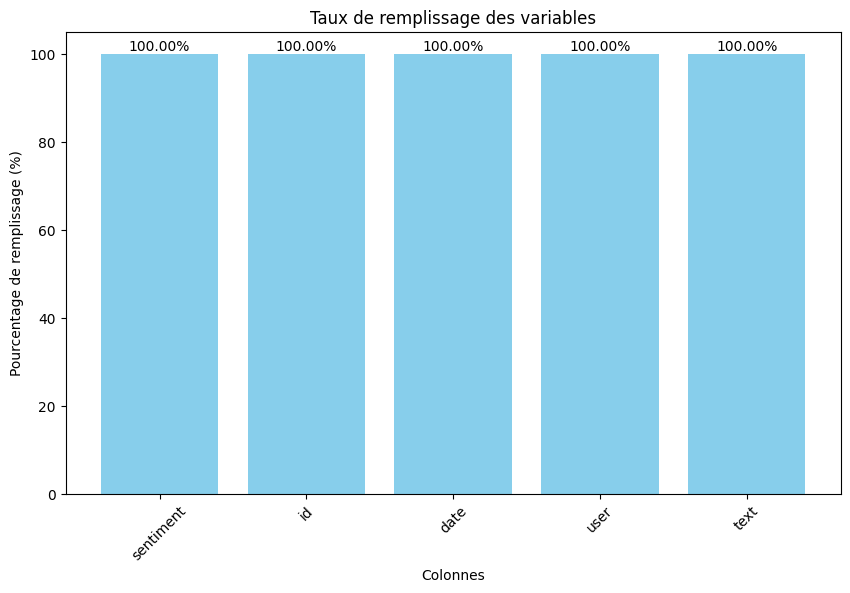

In [36]:
# Nettoyage du DataFrame avec MLFlow
with mlflow.start_run(run_name="Nettoyage des Données"):

    # Supprimer la colonne inutile
    df = df.drop(columns=['query'])

    # Convertir les labels de sentiment
    df['sentiment'] = df['sentiment'].replace({4: 1})
    sentiment_counts_after = df['sentiment'].value_counts().to_dict()
    mlflow.log_param("Répartition des sentiments après conversion", sentiment_counts_after)

    # Calculer et enregistrer le taux de remplissage des colonnes
    taux_remplissage = df.notnull().mean() * 100
    mlflow.log_dict(taux_remplissage.to_dict(), "Taux_remplissage.json")

    # Créer un graphique du taux de remplissage
    plt.figure(figsize=(10, 6))
    bars = plt.bar(taux_remplissage.index, taux_remplissage, color='skyblue')
    plt.title("Taux de remplissage des variables")
    plt.ylabel("Pourcentage de remplissage (%)")
    plt.xlabel("Colonnes")
    plt.xticks(rotation=45)

    # Ajouter les pourcentages au-dessus de chaque barre
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

    # Sauvegarder le graphique
    plt.savefig("taux_remplissage_colonnes.png")

    # Enregistrer le graphique dans MLFlow comme artefact
    mlflow.log_artifact("taux_remplissage_colonnes.png")

    # Suppression des doublons
    avant_doublons = len(df)
    df = df.drop_duplicates(subset=['text'])
    apres_doublons = len(df)
    mlflow.log_param("Tweets_supprimes_doublons", avant_doublons - apres_doublons)

    # Suppression des tweets vides
    avant_vides = len(df)
    df = df[df['text'].str.strip() != ""]
    apres_vides = len(df)
    mlflow.log_param("Tweets_supprimes_vides", avant_vides - apres_vides)

    # Log de la taille finale des données
    mlflow.log_param("Nombre total de tweets après nettoyage", len(df))

### <font color='blue'>3.3 Nettoyage du texte des tweets</font><a class="anchor" id="partie3.3">

###### <font color='orange'>Intégration dans MLFlow</font>

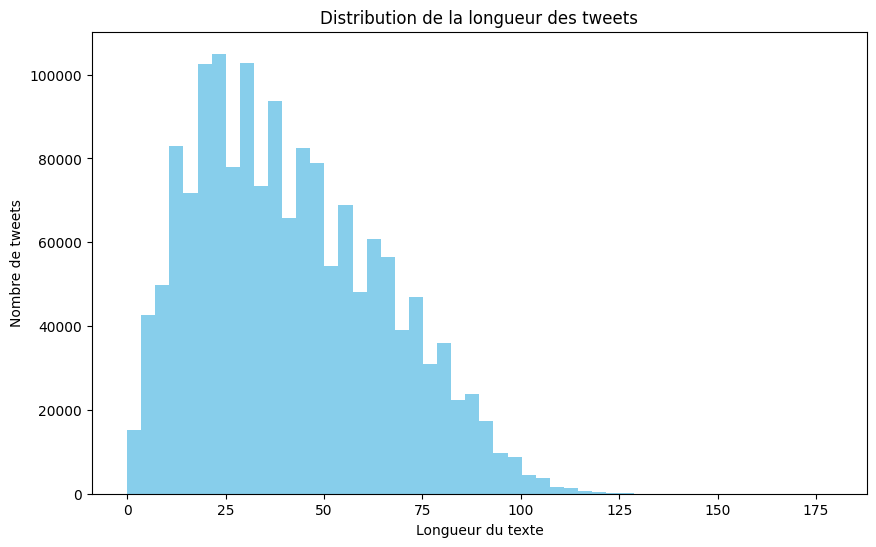

In [37]:
# Run principal pour les transformations de texte
with mlflow.start_run(run_name="Transformations du Texte des Tweets", nested=False):

    # Nettoyage du Texte des Tweets avec un sous-run
    with mlflow.start_run(run_name="Nettoyage du Texte", nested=True):
        df['text_cleaned'] = df['text'].apply(nettoyer_texte)
        sample_texts = df[['text', 'text_cleaned']].sample(5).to_string()
        mlflow.log_text(sample_texts, "Exemple_text_nettoye.txt")

    # Analyse de la Longueur des Tweets avec un sous-run
    with mlflow.start_run(run_name="Analyse de la Longueur des Tweets", nested=True):
        df['text_length'] = df['text_cleaned'].apply(len)
        plt.figure(figsize=(10, 6))
        plt.hist(df['text_length'], bins=50, color='skyblue')
        plt.title("Distribution de la longueur des tweets")
        plt.xlabel("Longueur du texte")
        plt.ylabel("Nombre de tweets")
        plt.savefig("distribution_longueur_tweets.png")
        mlflow.log_artifact("distribution_longueur_tweets.png")

In [38]:
# Nettoyage et suppression des lignes problématiques
df['text_cleaned'] = df['text_cleaned'].fillna(df['text'])  # Remplacer NaN par `text`
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['text_cleaned'] = df['text_cleaned'].replace('', np.nan)  # Remplacer les chaînes vides par NaN

# Supprimer les lignes problématiques
df = df[~df['text_cleaned'].isnull()]

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1573595 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1573595 non-null  int64 
 1   id            1573595 non-null  int64 
 2   date          1573595 non-null  object
 3   user          1573595 non-null  object
 4   text          1573595 non-null  object
 5   text_cleaned  1573595 non-null  object
 6   text_length   1573595 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 96.0+ MB


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1573595 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1573595 non-null  int64 
 1   id            1573595 non-null  int64 
 2   date          1573595 non-null  object
 3   user          1573595 non-null  object
 4   text          1573595 non-null  object
 5   text_cleaned  1573595 non-null  object
 6   text_length   1573595 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 96.0+ MB


###### **<font color='green'>Observations</font>**

- Répartition des Labels de Sentiment :
On observe un équilibre entre les tweets positifs et négatifs dans le dataset (800 000 pour chaque label). Cela est idéal pour l'entraînement d'un modèle de classification, car il ne sera pas biaisé par une classe dominante.

- Échantillons de Texte Nettoyé :
Les exemples montrent que la fonction de nettoyage fonctionne bien, retirant efficacement les mentions, les hashtags, la ponctuation, les chiffres et les espaces supplémentaires.
Les phrases sont prêtes pour les étapes d'analyse plus avancées.

- Distribution de la Longueur des Tweets :
Le graphique montre une distribution asymétrique, avec une majorité des tweets entre 25 et 75 caractères. Cela peut nous aider à définir des limites de longueur pour le modèle, ou des seuils pour le padding et le truncating lors de l'utilisation des embeddings ou de modèles séquentiels.

## <font color='red'>4. Prétraitement des données</font><a class="anchor" id="partie4"></a>

### <font color='blue'>4.1 Nettoyage des données</font><a class="anchor" id="partie4.1">

In [41]:
# Appliquer et loguer dans MLFlow
with mlflow.start_run(run_name="Stemmatisation et Lemmatisation", nested=False):
    try:
        # Appliquer et loguer la stemmatisation
        with mlflow.start_run(run_name="Stemmatisation", nested=True):
            df['text_stemmed'] = df['text_cleaned'].apply(stemmer_texte)
            mlflow.log_text(df[['text_cleaned', 'text_stemmed']].sample(5).to_string(), "exemple_text_stemmed.txt")

        # Appliquer et loguer la lemmatisation
        with mlflow.start_run(run_name="Lemmatisation", nested=True):
            df['text_lemmatized'] = df['text_cleaned'].apply(lemmatizer_texte)
            mlflow.log_text(df[['text_cleaned', 'text_lemmatized']].sample(5).to_string(), "exemple_text_lemmatized.txt")

        # Enregistrer le nombre total de tweets après transformations
        mlflow.log_param("Nombre total de tweets après transformations", len(df))

    except Exception as e:
        print(f"Erreur lors du nettoyage des données : {e}")

In [42]:
# Exporter les données nettoyées
df.to_csv('/content/drive/My Drive/projet_7/df_modele_final_vf.csv', index=False, encoding='utf-8')

### <font color='blue'>4.2 BoW et TF-IDF</font><a class="anchor" id="partie4.2">

In [ ]:
# Appliquer la vectorisation sur chaque colonne et méthode dans un run principal
with mlflow.start_run(run_name="Vectorisation des Textes", nested=False):
    vectorization_methods = ["BoW", "TF-IDF"]
    text_versions = ["text_cleaned", "text_stemmed", "text_lemmatized"]

    for vectorization_type in vectorization_methods:
        for column_name in text_versions:
            try:
                # Créer un sous-run pour chaque type de vectorisation
                with mlflow.start_run(run_name=f"Vectorisation {vectorization_type} - {column_name}", nested=True):
                    matrix = vectorize_and_log(df, column_name, vectorization_type=vectorization_type)

            except Exception as e:
                print(f"Erreur lors de la vectorisation {vectorization_type} pour {column_name} : {e}")

## <font color='red'>5. Modélisation Simple</font><a class="anchor" id="partie5"></a>


Entraînement de Régression Logistique avec BoW et text_cleaned

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---


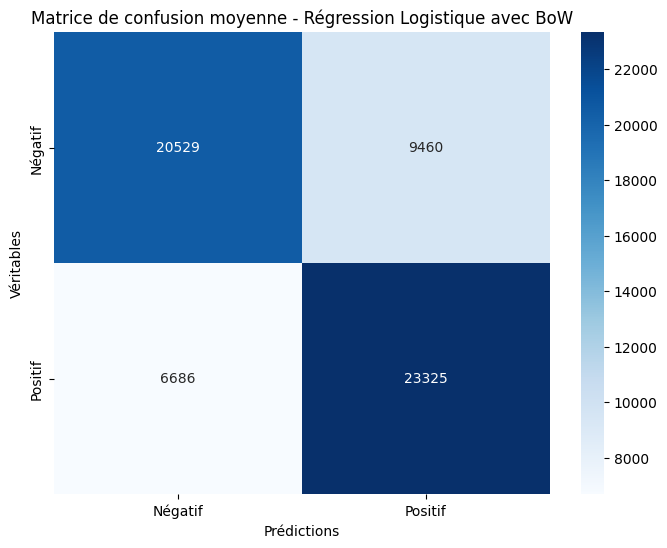

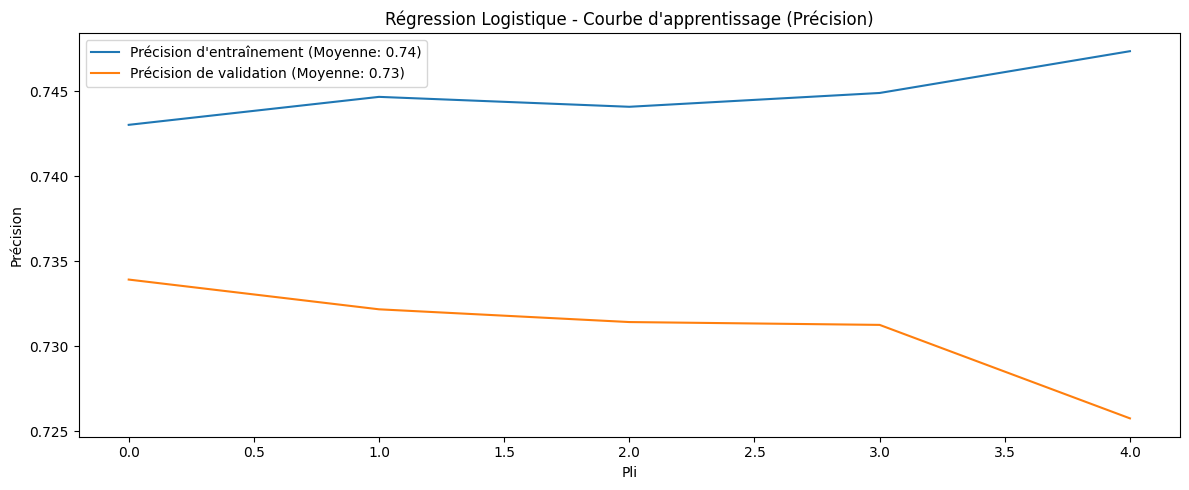

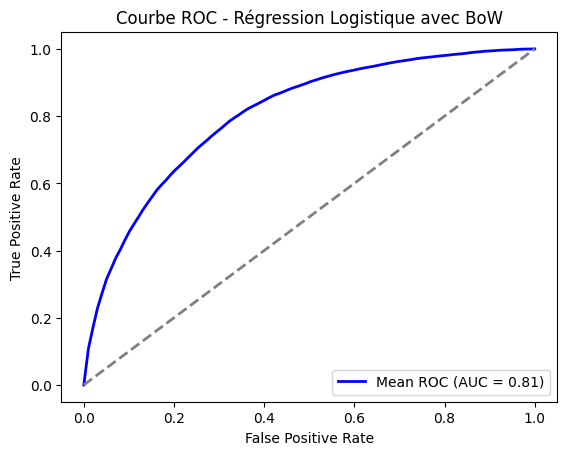


Entraînement de SVM avec BoW et text_cleaned

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---


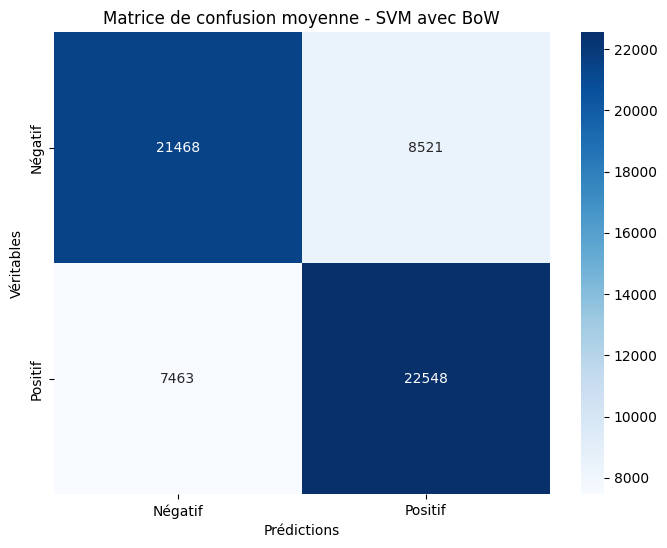

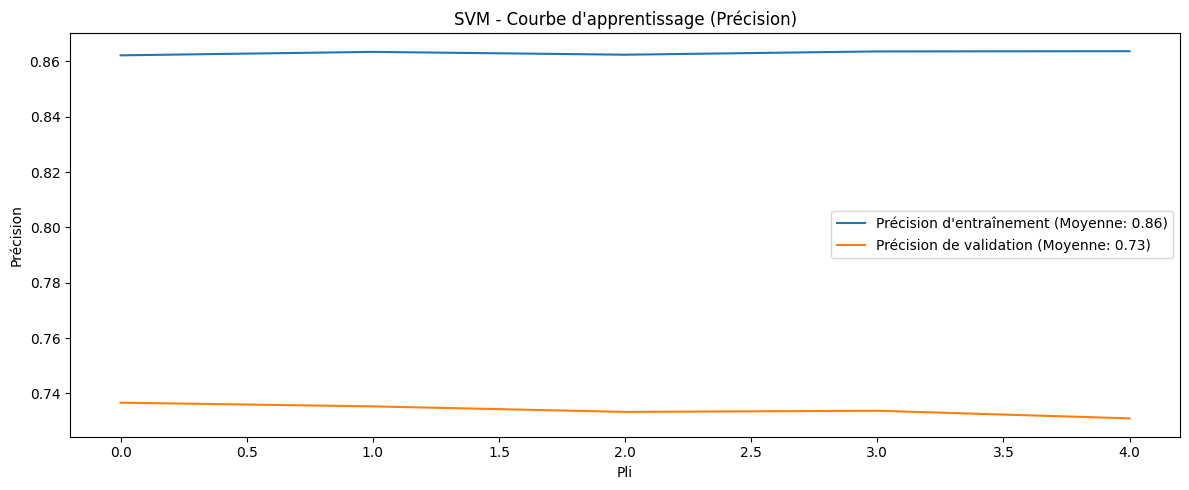

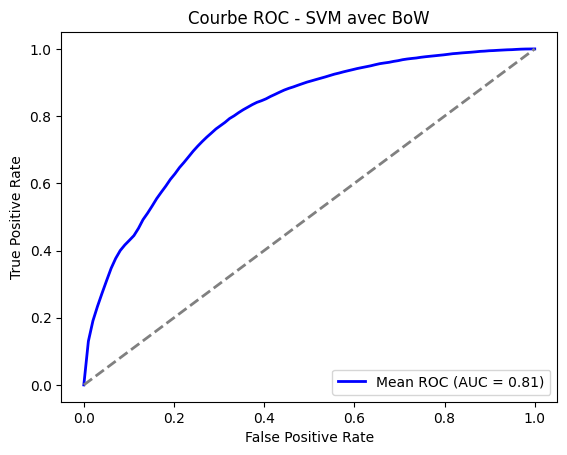


Entraînement de Régression Logistique avec TF-IDF et text_cleaned

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---


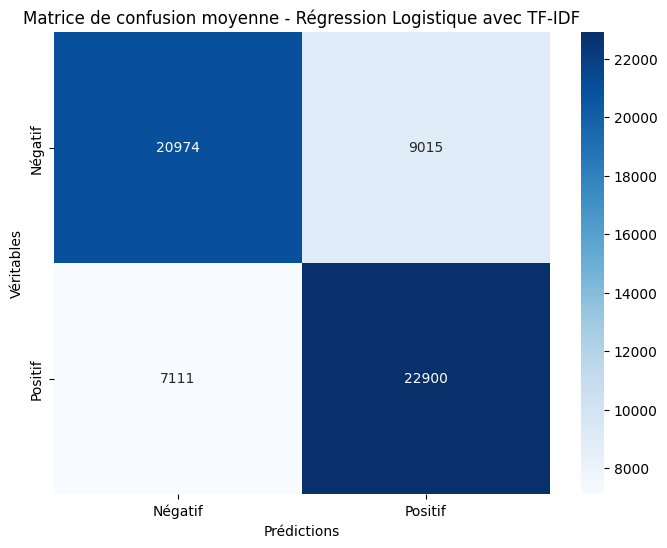

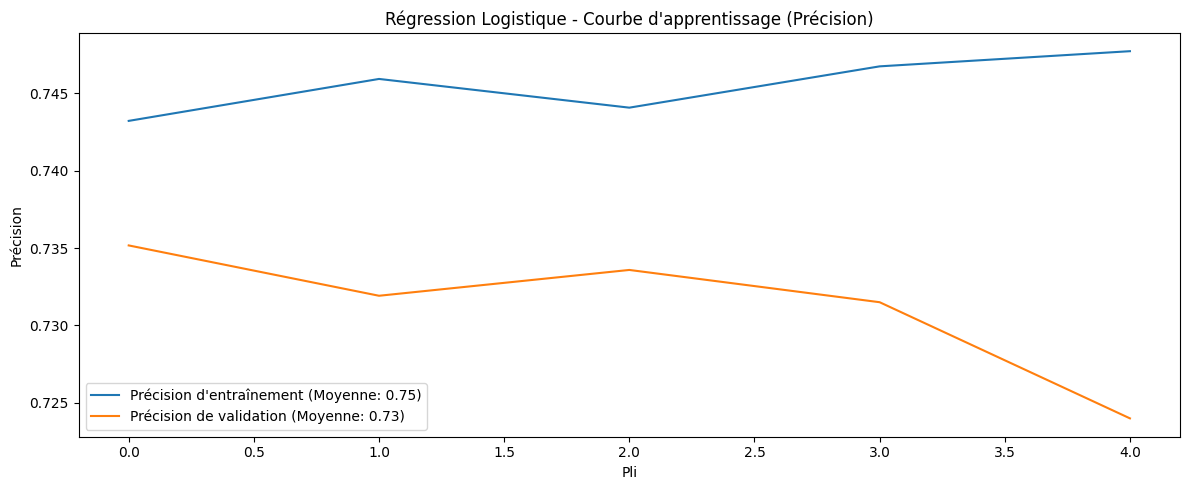

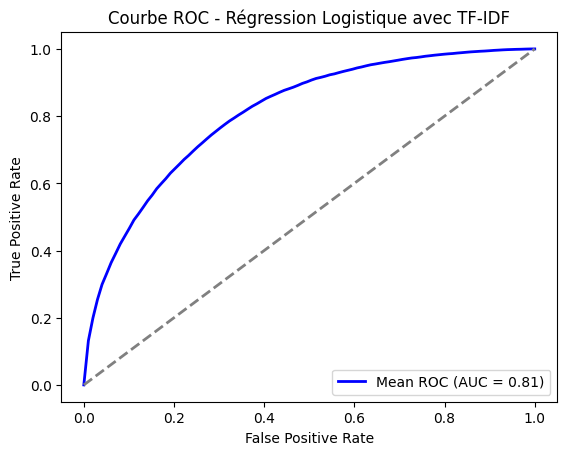


Entraînement de SVM avec TF-IDF et text_cleaned

--- Pli 1 ---

--- Pli 2 ---


In [ ]:
# Initialiser la liste globale des scores
model_scores = []

# Modèles à tester
log_reg = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)

# Dictionnaire des transformations et méthodes d'encodage
transformations = {
    "text_cleaned": ["BoW", "TF-IDF"],
    "text_stemmed": ["BoW", "TF-IDF"],
    "text_lemmatized": ["BoW", "TF-IDF"]
}

# Prendre un échantillon de 16 000 tweets
df_sample = df.sample(60000, random_state=42)

# Liste des modèles avec leurs noms pour les logs
models = {
    "Régression Logistique": log_reg,
    "SVM": svm
}

# Boucle mise à jour pour organiser les runs ML avec des runs principaux et des sous-runs
for text_version, vectorization_types in transformations.items():
    for vectorization_type in vectorization_types:
        # Créer un run principal pour chaque type de vectorisation et version de texte
        run_name = f"Modèle ML - {vectorization_type} - {text_version}"
        with mlflow.start_run(run_name=run_name, nested=False):
            mlflow.set_tag("Type de Vectorisation", vectorization_type)
            mlflow.set_tag("Version Texte", text_version)

            # Obtenir la matrice de features pour la combinaison (texte, vectorization_type)
            X = vectorize_and_log(df_sample, text_version, vectorization_type=vectorization_type)
            y = df_sample['sentiment'].values  # Variable cible

            for model_name, model in models.items():
                # Créer un sous-run pour chaque modèle
                with mlflow.start_run(run_name=model_name, nested=True):
                    mlflow.set_tag("Modèle", model_name)

                    # Entraîner et évaluer le modèle avec validation croisée stratifiée
                    print(f"\nEntraînement de {model_name} avec {vectorization_type} et {text_version}")
                    train_and_evaluate_ml_model(
                        model=model,
                        model_name=model_name,
                        embedding_data=X,
                        labels=y,
                        embedding_type=vectorization_type
                    )

##### **<font color='green'>Comparatif</font>**

In [ ]:
# Appel de la fonction pour afficher le tableau récapitulatif
df_summary_ml = display_score_summary_ml()

In [ ]:
display(df_summary_ml)

## <font color='red'>6. Modélisation Avancée</font><a class="anchor" id="partie6"></a>


### <font color='blue'>6.1 Word Embedding</font><a class="anchor" id="partie6.1"></a>

###### **<font color='green'>Word2Vec</font>**

In [43]:
!pip install gensim

In [45]:
from gensim.models import Word2Vec

# 1. Préparer les phrases (liste de listes de mots) à partir des tweets
sentences = df['text_stemmed'].apply(lambda x: x.split()).tolist()

# 2. Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# 3. Sauvegarder le modèle pour une utilisation future
word2vec_model.save("/content/drive/My Drive/projet_7/word2vec_tweets.model")

# Loguer l'embedding dans MLFlow
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Entraînement Word2Vec"):
    mlflow.log_param("vector_size", 100)
    mlflow.log_param("window", 5)
    mlflow.log_param("min_count", 5)
    mlflow.log_artifact("/content/drive/My Drive/projet_7/word2vec_tweets.model")

In [ ]:
# Vérifier l'existence de mots dans le vocabulaire avant de demander les mots similaires
def print_similar_words(word, model, topn=5):
    if word in model.wv:
        print(f"Mots similaires à '{word}': {model.wv.most_similar(word, topn=topn)}")
    else:
        print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")

# Tester avec des mots plus fréquents dans le domaine aérien
print_similar_words("plane", word2vec_model)
print_similar_words("late", word2vec_model)
print_similar_words("fly", word2vec_model)  # Essayer d'autres termes courants

Mots similaires à 'plane': [('flight', 0.8018579483032227), ('airplan', 0.744377851486206), ('airport', 0.6761336326599121), ('sfo', 0.6533602476119995), ('atlant', 0.6484527587890625)]
Mots similaires à 'late': [('earli', 0.6691061854362488), ('earlier', 0.5876843929290771), ('pm', 0.5053351521492004), ('tire', 0.49032241106033325), ('midnight', 0.47978416085243225)]
Le mot 'fly' n'est pas dans le vocabulaire du modèle.


###### **<font color='green'>USE</font>**

In [ ]:
!pip install tensorflow tensorflow-hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

# Charger le modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour transformer les tweets en embeddings par lots
def batch_embeddings(sentences, batch_size=128):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_emb = use_model(batch)
        embeddings.append(batch_emb.numpy())
    return np.vstack(embeddings)

# Calculer les embeddings en batchs pour éviter les problèmes de mémoire
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Embeddings USE"):
    tweets = df['text_stemmed'].tolist()
    use_embeddings = batch_embeddings(tweets)
    mlflow.log_param("embedding_type", "USE")
    # Loguer une partie des embeddings en tant qu'artefact pour inspection
    np.save("use_embeddings_sample.npy", use_embeddings[:5])  # Sauvegarde d'un échantillon
    mlflow.log_artifact("use_embeddings_sample.npy")

### <font color='blue'>6.2 Modelisation</font><a class="anchor" id="partie6.2"></a>

##### **<font color='green'>KERAS Dense</font>**


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7189 - loss: 0.5510 - val_accuracy: 0.7477 - val_loss: 0.5094
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - accuracy: 0.7418 - loss: 0.5227 - val_accuracy: 0.7516 - val_loss: 0.5050
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7442 - loss: 0.5186 - val_accuracy: 0.7530 - val_loss: 0.5018
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7452 - loss: 0.5170 - val_accuracy: 0.7539 - val_loss: 0.5015
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7455 - loss: 0.5159 - val_accuracy: 0.7546 - val_loss: 0.5006
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7473 - loss: 0.5145 - val_accuracy: 0.7547 - val_loss: 0.5021
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7470 - loss: 0.5144 - val_accuracy: 0.7554 - val_loss: 0.5009
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/st

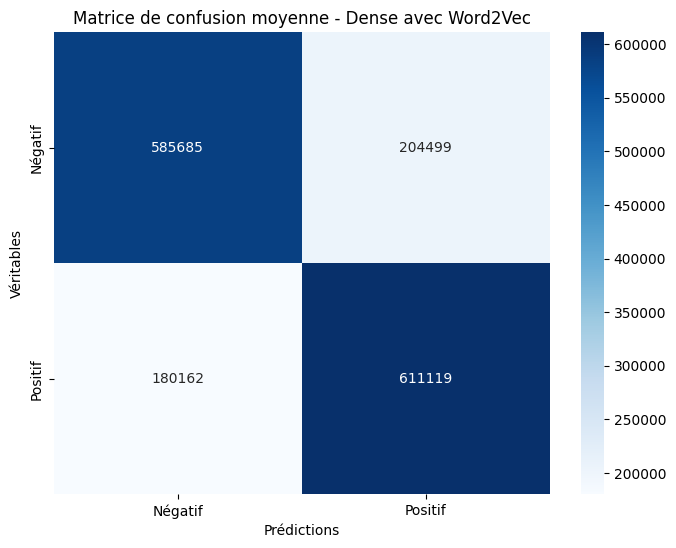

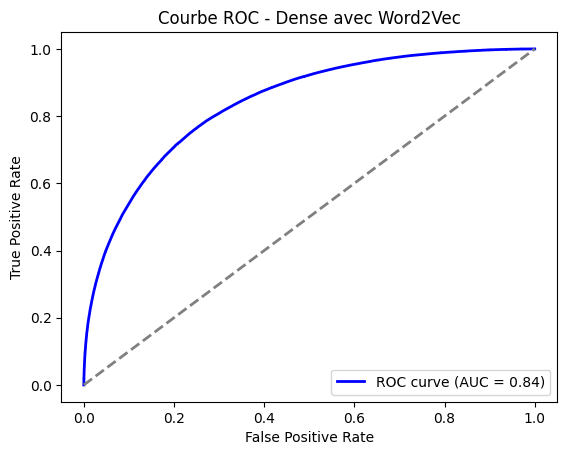

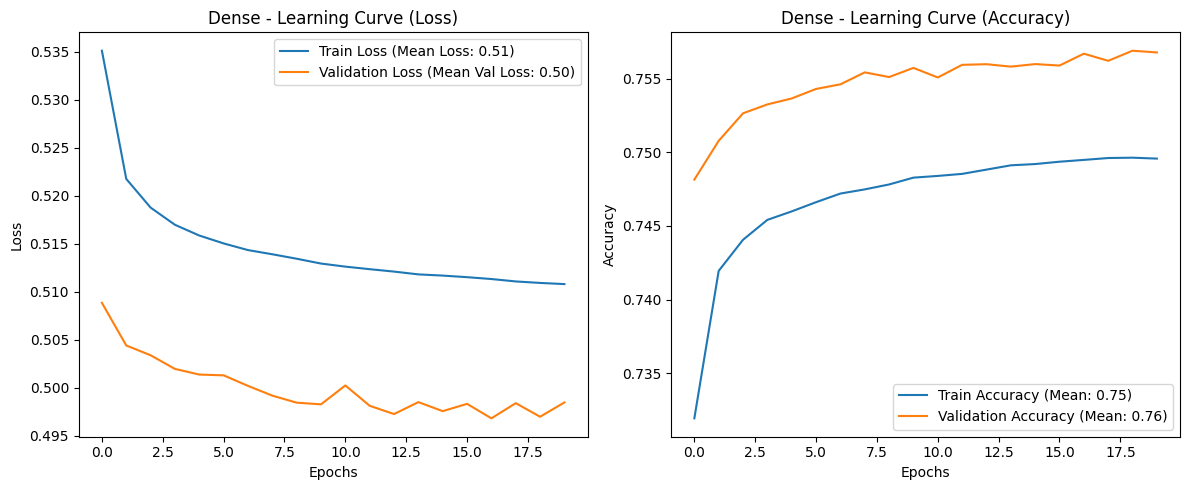


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.7152 - loss: 0.5522 - val_accuracy: 0.7384 - val_loss: 0.5198
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.7338 - loss: 0.5300 - val_accuracy: 0.7414 - val_loss: 0.5154
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7374 - loss: 0.5254 - val_accuracy: 0.7426 - val_loss: 0.5128
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.7386 - loss: 0.5243 - val_accuracy: 0.7433 - val_loss: 0.5122
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7396 - loss: 0.5220 - val_accuracy: 0.7444 - val_loss: 0.5118
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.7407 - loss: 0.5201 - val_accuracy: 0.7449 - val_loss: 0.5103
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.7412 - loss: 0.5194 - val_accuracy: 0.7452 - val_loss: 0.5094
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/st

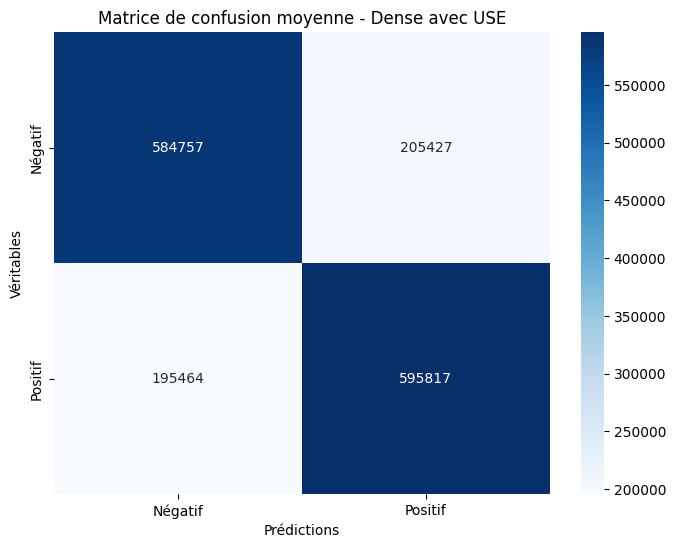

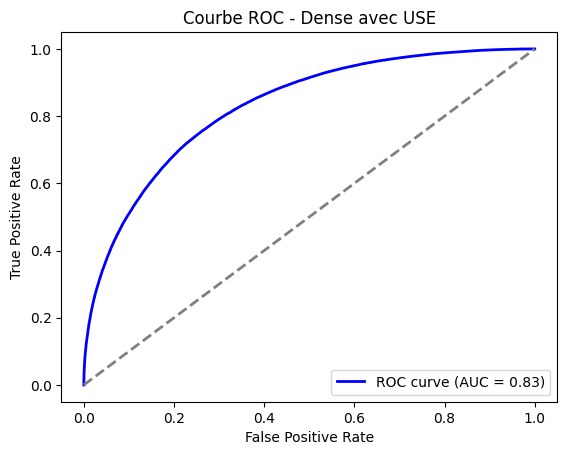

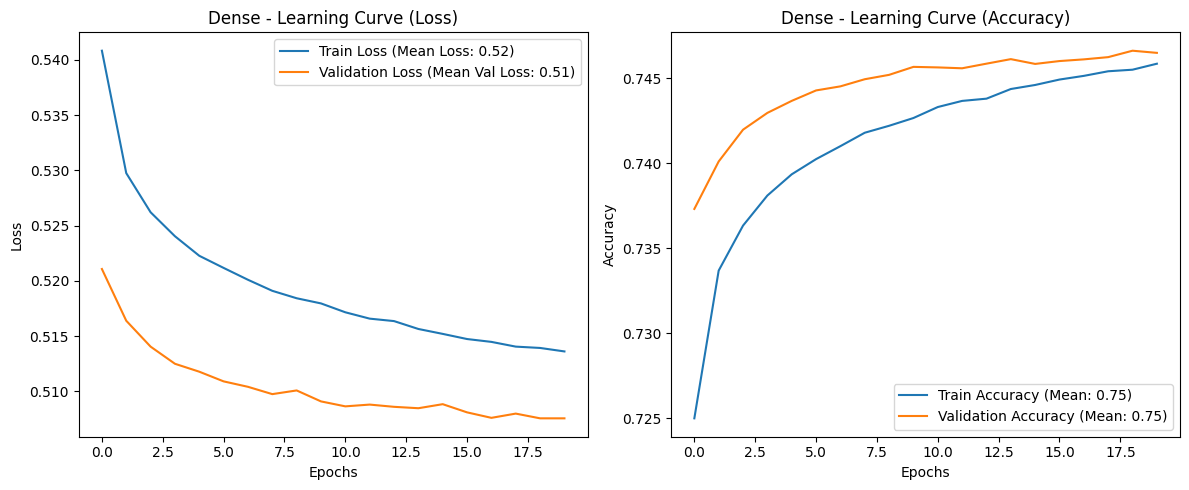

In [ ]:
# Obtenir les embeddings Word2Vec et USE
word2vec_embeddings = get_avg_word2vec_embeddings(df['text_stemmed'].apply(str.split), word2vec_model, 100)
use_embeddings = batch_embeddings(df['text_stemmed'].tolist())

# Exécuter le modèle Dense avec Word2Vec
with mlflow.start_run(run_name="Keras - Dense - Word2Vec", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=word2vec_embeddings,
        labels=df['sentiment'].values,
        embedding_type="Word2Vec"
    )

# Exécuter le modèle Dense avec USE
with mlflow.start_run(run_name="Keras - Dense - USE", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=use_embeddings,
        labels=df['sentiment'].values,
        embedding_type="USE"
    )

##### **<font color='green'>KERAS LSTM</font>**


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.7297 - loss: 0.5327 - val_accuracy: 0.7504 - val_loss: 0.5031
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.7469 - loss: 0.5089 - val_accuracy: 0.7538 - val_loss: 0.4979
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7492 - loss: 0.5058 - val_accuracy: 0.7549 - val_loss: 0.4957
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.7503 - loss: 0.5040 - val_accuracy: 0.7563 - val_loss: 0.4935
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.7522 - loss: 0.5012 - val_accuracy: 0.7578 - val_loss: 0.4925
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.7529 - loss: 0.5002 - val_accuracy: 0.7579 - val_loss: 0.4915
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7534 - loss: 0.4999 - val_accuracy: 0.7583 - val_loss: 0.4908
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/st

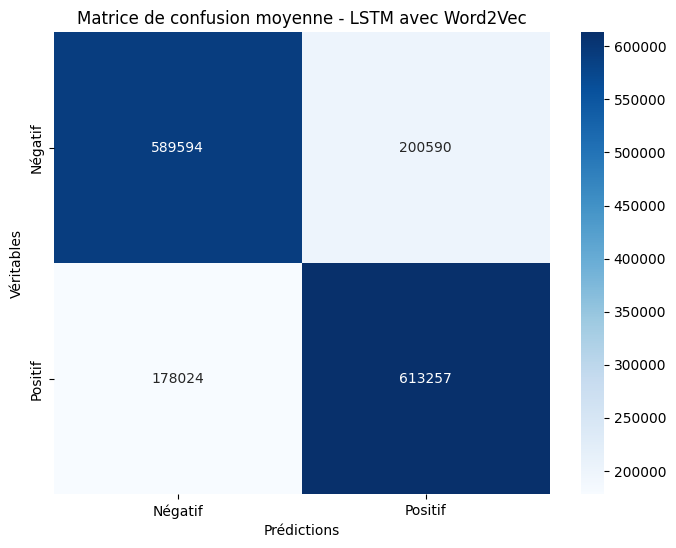

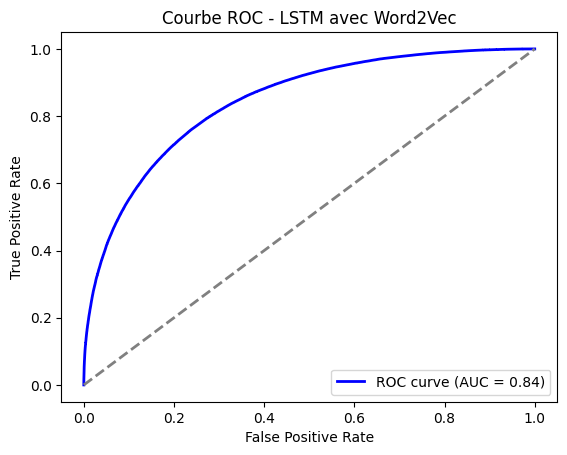

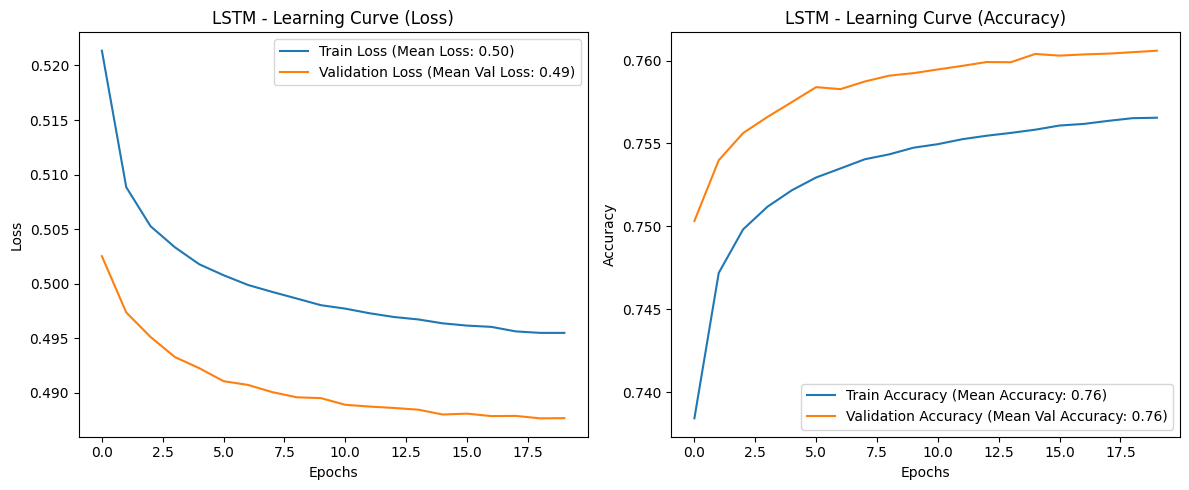


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7132 - loss: 0.5527 - val_accuracy: 0.7331 - val_loss: 0.5255
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7306 - loss: 0.5294 - val_accuracy: 0.7374 - val_loss: 0.5184
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7348 - loss: 0.5244 - val_accuracy: 0.7401 - val_loss: 0.5152
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7371 - loss: 0.5213 - val_accuracy: 0.7419 - val_loss: 0.5125
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7395 - loss: 0.5182 - val_accuracy: 0.7433 - val_loss: 0.5112
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7399 - loss: 0.5175 - val_accuracy: 0.7442 - val_loss: 0.5096
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7412 - loss: 0.5158 - val_accuracy: 0.7452 - val_loss: 0.5088
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/st

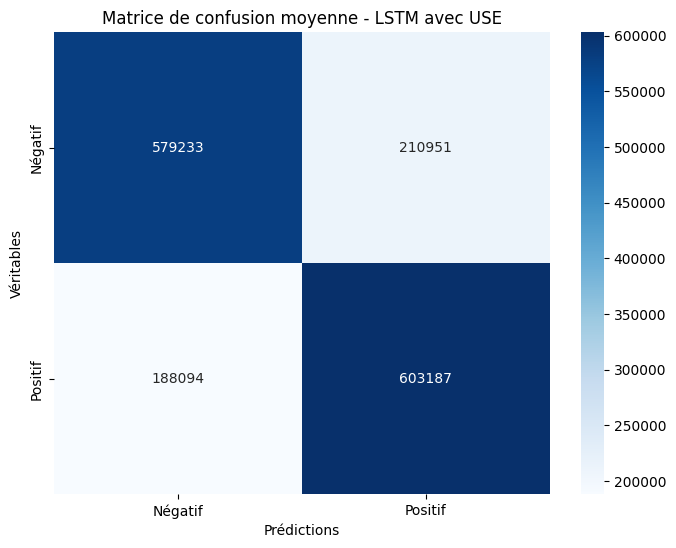

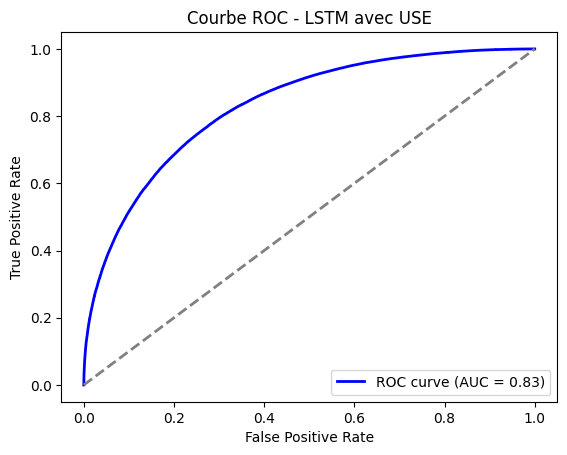

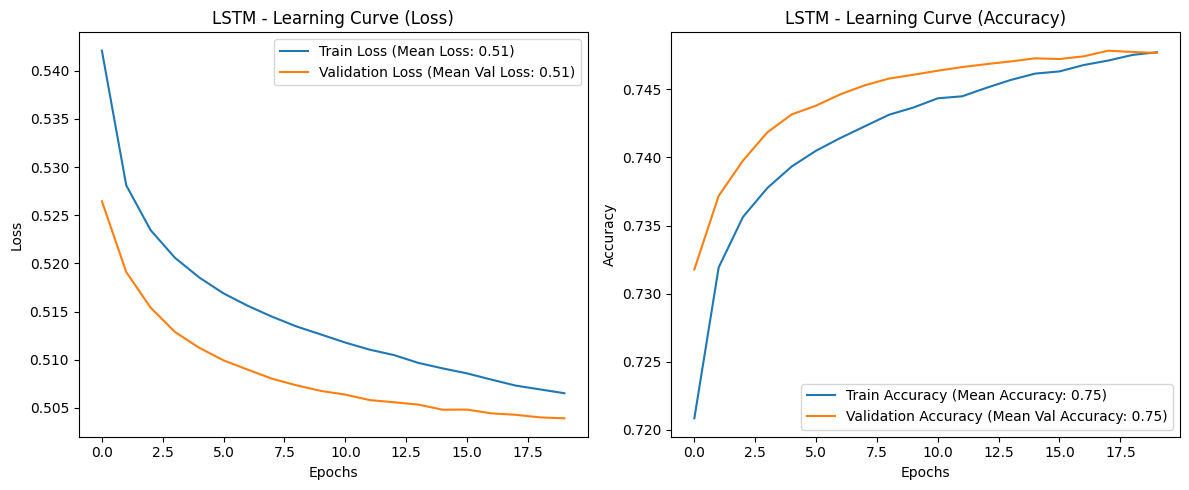

In [ ]:
# Initialiser la liste globale des scores pour les modèles Keras
model_scores_keras = []

# Initialiser les embeddings
word2vec_embeddings = get_avg_word2vec_embeddings(df['text_stemmed'].apply(str.split), word2vec_model, 100)
use_embeddings = batch_embeddings(df['text_stemmed'].tolist())

# Vérifier et transformer les embeddings en 3D si nécessaire
if len(word2vec_embeddings.shape) == 2:
    word2vec_embeddings = word2vec_embeddings[:, np.newaxis, :]
if len(use_embeddings.shape) == 2:
    use_embeddings = use_embeddings[:, np.newaxis, :]

# Créer le run principal pour Keras - LSTM
ensure_no_active_run()
with mlflow.start_run(run_name="KERAS - LSTM", nested=False):
    # Exécuter l’entraînement pour Word2Vec en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="Word2Vec", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM",
            embedding_data=word2vec_embeddings,
            labels=df['sentiment'].values,
            embedding_type="Word2Vec",
            bidirectional=False
        )

    # Exécuter l’entraînement pour USE en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="USE", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM",
            embedding_data=use_embeddings,
            labels=df['sentiment'].values,
            embedding_type="USE",
            bidirectional=False
        )

##### **<font color='green'>KERAS LSTM Bidirectionnel</font>**


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.7300 - loss: 0.5310 - val_accuracy: 0.7526 - val_loss: 0.5007
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7499 - loss: 0.5044 - val_accuracy: 0.7561 - val_loss: 0.4947
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7529 - loss: 0.4987 - val_accuracy: 0.7585 - val_loss: 0.4919
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7549 - loss: 0.4964 - val_accuracy: 0.7599 - val_loss: 0.4892
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - accuracy: 0.7566 - loss: 0.4941 - val_accuracy: 0.7594 - val_loss: 0.4893
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7578 - loss: 0.4920 - val_accuracy: 0.7614 - val_loss: 0.4874
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7579 - loss: 0.4924 - val_accuracy: 0.7607 - val_loss: 0.4865
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/st

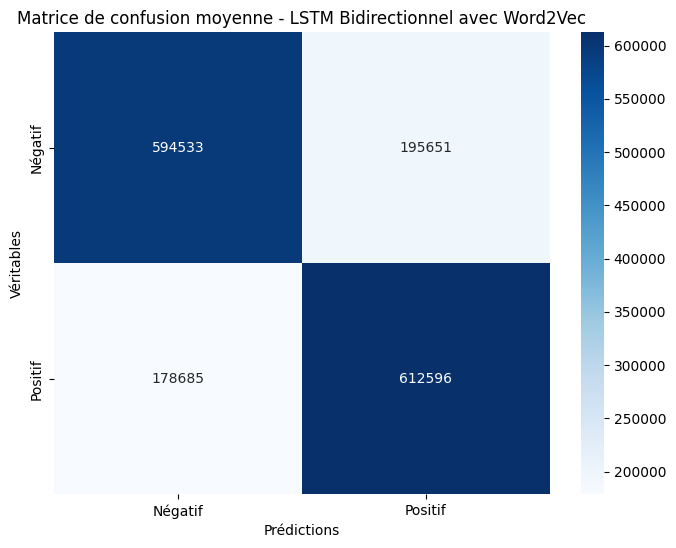

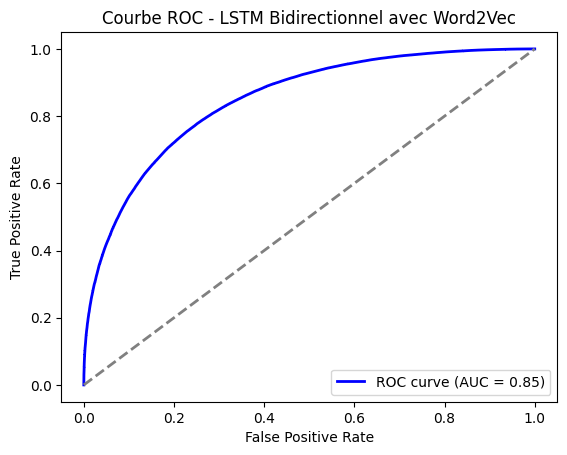

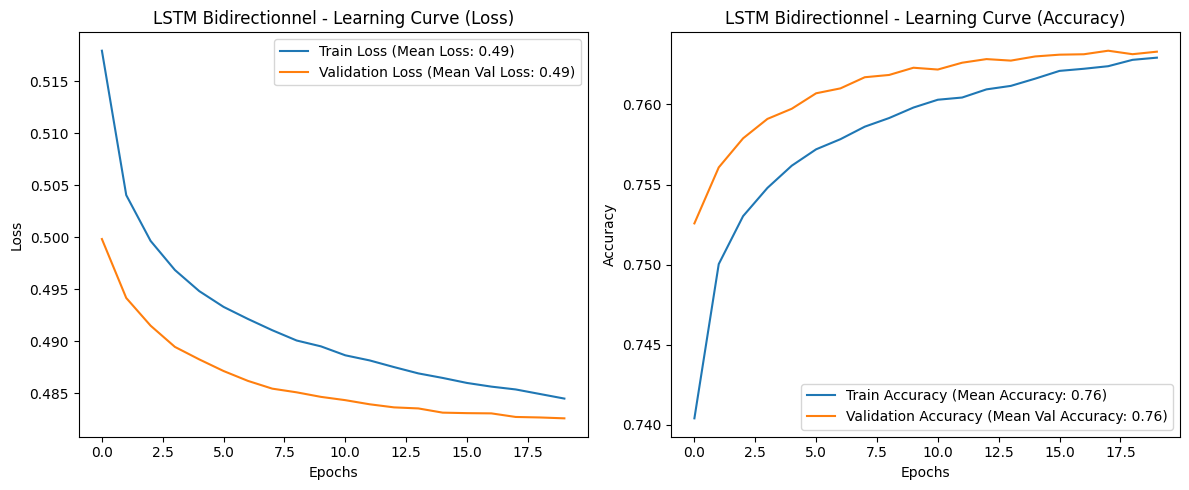


--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.7146 - loss: 0.5497 - val_accuracy: 0.7347 - val_loss: 0.5230
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.7336 - loss: 0.5252 - val_accuracy: 0.7404 - val_loss: 0.5153
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7393 - loss: 0.5181 - val_accuracy: 0.7431 - val_loss: 0.5110
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7415 - loss: 0.5146 - val_accuracy: 0.7449 - val_loss: 0.5081
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.7434 - loss: 0.5118 - val_accuracy: 0.7457 - val_loss: 0.5066
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7465 - loss: 0.5077 - val_accuracy: 0.7473 - val_loss: 0.5049
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.7475 - loss: 0.5062 - val_accuracy: 0.7480 - val_loss: 0.5042
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/

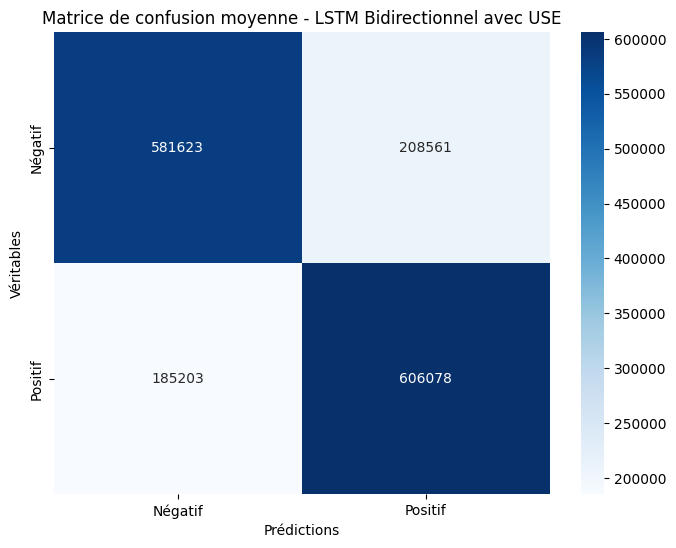

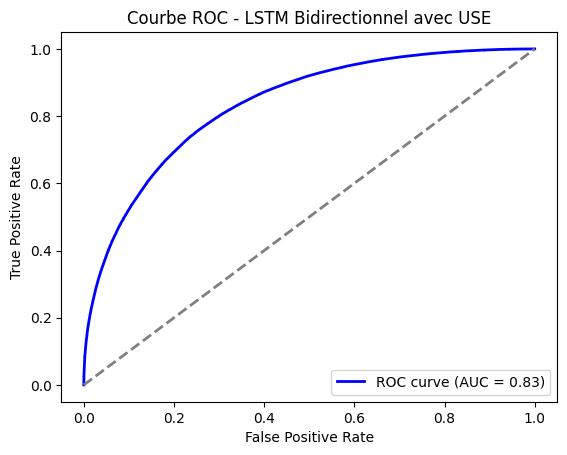

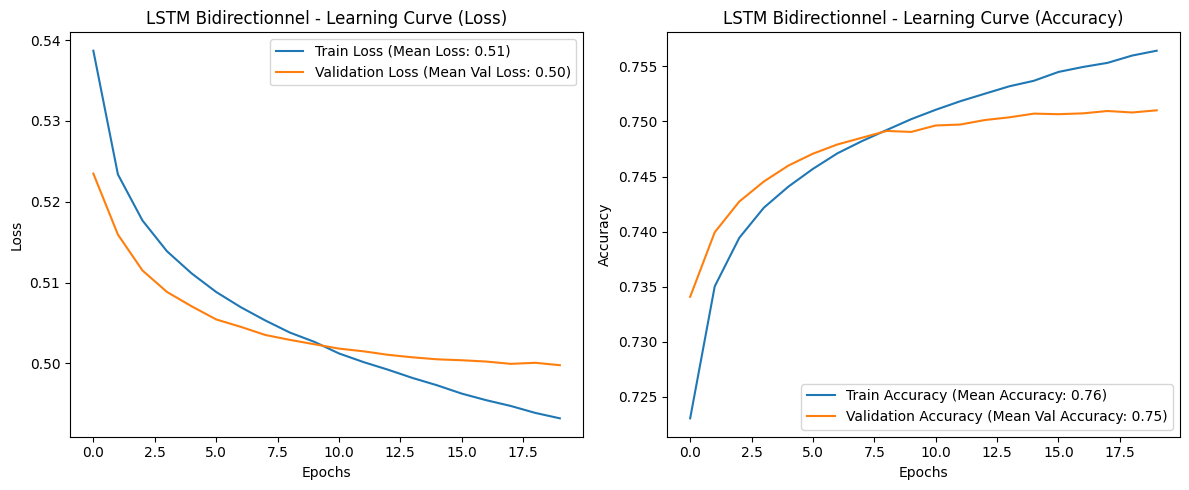

In [ ]:
# Initialiser la liste globale des scores pour les modèles Keras
model_scores_keras = []

# Initialiser les embeddings
word2vec_embeddings = get_avg_word2vec_embeddings(df['text_stemmed'].apply(str.split), word2vec_model, 100)
use_embeddings = batch_embeddings(df['text_stemmed'].tolist())

# Vérifier et transformer les embeddings en 3D si nécessaire
if len(word2vec_embeddings.shape) == 2:
    word2vec_embeddings = word2vec_embeddings[:, np.newaxis, :]
if len(use_embeddings.shape) == 2:
    use_embeddings = use_embeddings[:, np.newaxis, :]

# Créer le run principal pour Keras - LSTM Bidirectionnel
ensure_no_active_run()
with mlflow.start_run(run_name="KERAS - LSTM Bidirectionnel", nested=False):
    # Exécuter l’entraînement pour Word2Vec en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="Word2Vec", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM Bidirectionnel",
            embedding_data=word2vec_embeddings,
            labels=df['sentiment'].values,
            embedding_type="Word2Vec",
            bidirectional=True
        )

    # Exécuter l’entraînement pour USE en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="USE", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM Bidirectionnel",
            embedding_data=use_embeddings,
            labels=df['sentiment'].values,
            embedding_type="USE",
            bidirectional=True
        )

##### **<font color='green'>Comparatif</font>**

In [ ]:
# Appel de la fonction pour afficher le tableau récapitulatif
df_summary_keras = display_score_summary_keras()
display(df_summary_keras)

Empty DataFrame
Columns: []
Index: []


""


## <font color='red'>7. Modèle BERT</font><a class="anchor" id="partie7"></a>

### <font color='blue'>7.1 Test Pipeline HuggingFace</font><a class="anchor" id="partie7.1"></a>

In [ ]:
from transformers import pipeline

In [ ]:
# Initialiser le pipeline d'analyse de sentiments avec le modèle RoBERTa
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Appliquer le pipeline sur un échantillon de tweets (par exemple, les 50 premiers)
sample_texts = df['text_stemmed'].tolist()[:50]
results = sentiment_pipeline(sample_texts)

# Afficher les résultats pour chaque tweet
for i, result in enumerate(results):
    print(f"Texte {i+1}: {sample_texts[i]}")
    print(f"Sentiment: {result['label']}, Score: {result['score']:.4f}")
    print("---")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Texte 1: upset can not updat facebook text might cri result school today also blah
Sentiment: LABEL_0, Score: 0.9076
---
Texte 2: dive mani time ball manag save rest go bound
Sentiment: LABEL_1, Score: 0.8472
---
Texte 3: whole bodi feel itchi like fire
Sentiment: LABEL_1, Score: 0.7336
---
Texte 4: behav mad can not see
Sentiment: LABEL_0, Score: 0.6178
---
Texte 5: whole crew
Sentiment: LABEL_1, Score: 0.7274
---
Texte 6: need hug
Sentiment: LABEL_1, Score: 0.6576
---
Texte 7: hey long time see ye rain bit bit lol fine thank
Sentiment: LABEL_2, Score: 0.7980
---
Texte 8: nope
Sentiment: LABEL_1, Score: 0.4958
---
Texte 9: que muera
Sentiment: LABEL_1, Score: 0.5990
---
Texte 10: spring break plain citi snow
Sentiment: LABEL_1, Score: 0.8633
---
Texte 11: repierc ear
Sentiment: LABEL_1, Score: 0.6886
---
Texte 12: could bear watch thought ua loss embarrass
Sentiment: LABEL_0, Score: 0.6260
---
Texte 13: count know either never talk anymor
Sentiment: LABEL_1, Score: 0.5240
---
Texte 14

### <font color='blue'>7.2 Première approche</font><a class="anchor" id="partie7.2"></a>

In [ ]:
with open('/content/drive/My Drive/projet_7/token.txt', 'r') as file:
    hf_token = file.read().strip()

from huggingface_hub import login
login(hf_token)

In [ ]:
# Charger le modèle BERT et le tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Fonction pour obtenir les embeddings de phrase avec BERT par lots
def get_bert_embeddings_batch(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = bert_model(inputs)
        sentence_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)  # Moyenne sur la séquence
        all_embeddings.append(sentence_embeddings.numpy())
    return np.vstack(all_embeddings)

# Appliquer l'embedding BERT aux tweets en lots (sur tout le jeu de données)
with mlflow.start_run(run_name="Embedding BERT (Full Dataset)"):
    bert_embeddings = get_bert_embeddings_batch(df['text_stemmed'].tolist())
    print("Forme des embeddings BERT:", bert_embeddings.shape)
    np.save("bert_embeddings_full.npy", bert_embeddings)
    mlflow.log_artifact("bert_embeddings_full.npy")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Forme des embeddings BERT: (1581465, 768)



--- Pli 1 ---
Epoch 1/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - accuracy: 0.7027 - loss: 0.5637 - val_accuracy: 0.7253 - val_loss: 0.5357
Epoch 2/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7244 - loss: 0.5377 - val_accuracy: 0.7320 - val_loss: 0.5280
Epoch 3/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7291 - loss: 0.5316 - val_accuracy: 0.7341 - val_loss: 0.5229
Epoch 4/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7325 - loss: 0.5271 - val_accuracy: 0.7366 - val_loss: 0.5197
Epoch 5/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7350 - loss: 0.5235 - val_accuracy: 0.7386 - val_loss: 0.5186
Epoch 6/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7364 - loss: 0.5211 - val_accuracy: 0.7381 - val_loss: 0.5180
Epoch 7/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7383 - loss: 0.5188 - val_accuracy: 0.7405 - val_loss: 0.5156
Epoch 8/20
19769/19769 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/s

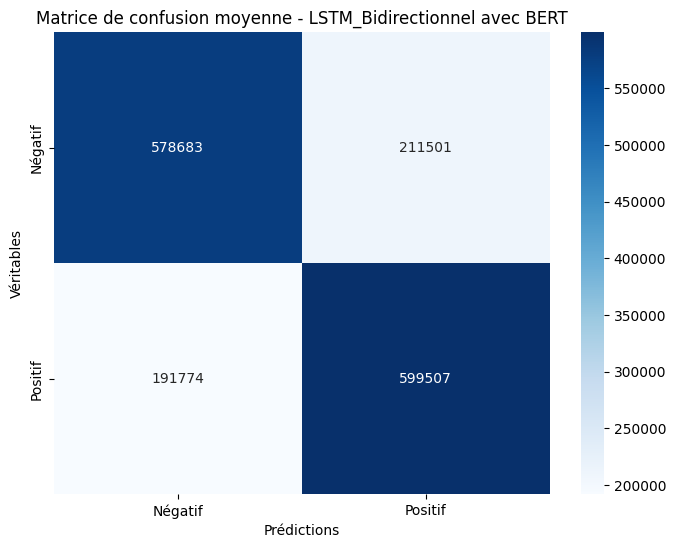

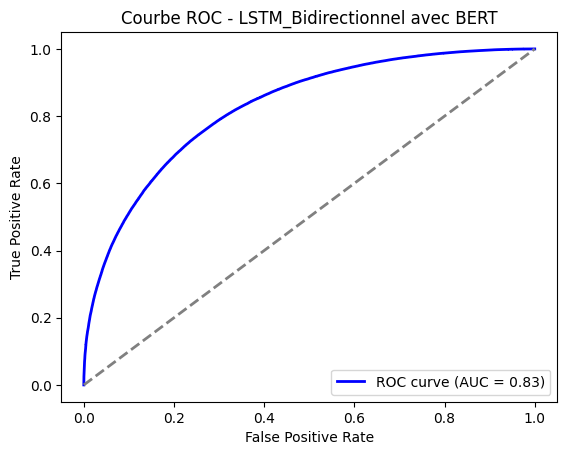

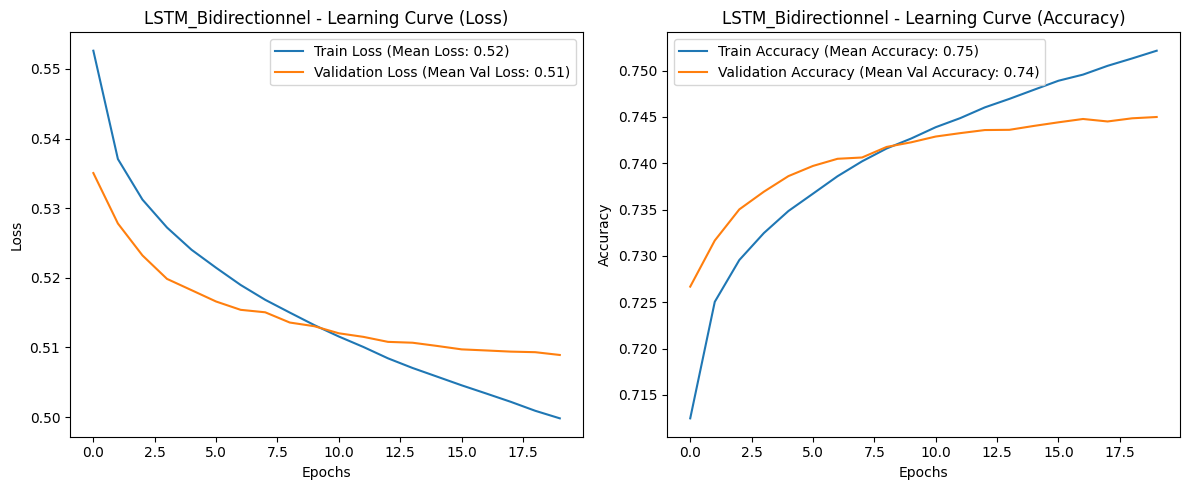

In [ ]:
# Initialiser la liste globale des scores pour les modèles Keras
model_scores_keras = []

# Vérifier et transformer les embeddings BERT en 3D si nécessaire
if len(bert_embeddings.shape) == 2:
    bert_embeddings = bert_embeddings[:, np.newaxis, :]

# Lancer le run principal pour l'intégration MLflow
if mlflow.active_run():
    mlflow.end_run()

# Entraînement du modèle LSTM bidirectionnel avec l'embedding BERT
with mlflow.start_run(run_name="LSTM_Bidirectionnel_BERT_Full_Dataset", nested=False):
    train_and_evaluate_keras_model_lstm(
        model_name="LSTM_Bidirectionnel",
        embedding_data=bert_embeddings,
        labels=df['sentiment'].values,
        embedding_type="BERT",
        bidirectional=True
    )

    # Loguer les informations d'embedding et le modèle dans MLflow
    mlflow.log_param("Embedding", "BERT")
    mlflow.log_param("Model_Type", "LSTM_Bidirectionnel")
    mlflow.log_param("Batch_Size", 64)
    mlflow.log_param("Epochs", 20)
    mlflow.log_text("Modèle avec embedding BERT et architecture LSTM bidirectionnelle", "description.txt")

### <font color='blue'>7.3 Deuxième approche</font><a class="anchor" id="partie7.3"></a>

In [ ]:
!pip install tensorflow --upgrade
!pip install transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Époque 1/3
Perte moyenne : 0.6651873928308487
Précision : 0.5850340136054422, Rappel : 0.8113207547169812, F1 Score : 0.6798418972332015, Exactitude : 0.595


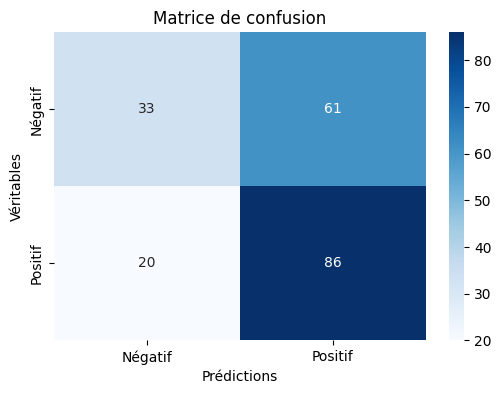

Époque 2/3
Perte moyenne : 0.49342217803001404
Précision : 0.7428571428571429, Rappel : 0.49056603773584906, F1 Score : 0.5909090909090909, Exactitude : 0.64


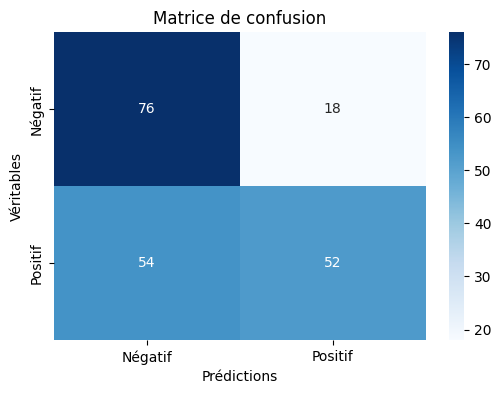

Époque 3/3
Perte moyenne : 0.24705482337623835
Précision : 0.7391304347826086, Rappel : 0.4811320754716981, F1 Score : 0.5828571428571429, Exactitude : 0.635


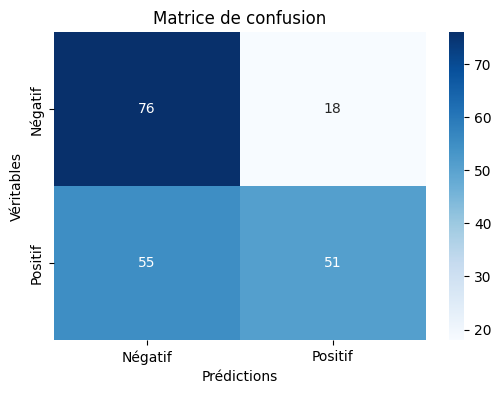

In [ ]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle et tokenizer Bert pour PyTorch
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Réduire les données à un échantillon de 1000 tweets
df_sample = df.sample(1000, random_state=42)

# Diviser les textes et labels pour l'échantillon
texts = df_sample['text_stemmed'].values
labels = df_sample['sentiment'].values

# Diviser les données en train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Définir un Dataset personnalisé
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs

# Créer les datasets et data loaders
train_dataset = SentimentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = SentimentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Configurer l'optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Définir une fonction d'entraînement
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    for epoch in range(epochs):
        print(f"Époque {epoch + 1}/{epochs}")

        # Mode entraînement
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        print(f"Perte moyenne : {avg_loss}")

        # Évaluation
        evaluate_model(model, val_loader, device)

# Définir une fonction d'évaluation
def evaluate_model(model, val_loader, device):
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(inputs["labels"].cpu().numpy())

    # Calcul des métriques
    accuracy = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    print(f"Précision : {precision}, Rappel : {recall}, F1 Score : {f1}, Exactitude : {accuracy}")

    # Matrice de confusion
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Véritables")
    plt.title("Matrice de confusion")
    plt.show()

# Entraîner le modèle
train_model(model, train_loader, val_loader, optimizer, device, epochs=3)

In [ ]:
# Vérifier la distribution des classes
class_counts = df['sentiment'].value_counts()

# Afficher le nombre d'échantillons par classe
print("Distribution des classes :")
print(class_counts)

# Visualiser la distribution des classes
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues")
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes dans le dataset")
plt.show()

##### test modele Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Device utilisé : cpu


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Époque 1 - Perte moyenne : 0.696643214225769
Époque 2 - Perte moyenne : 0.6787722820043564
Époque 3 - Perte moyenne : 0.5911198800802231
Accuracy: 0.5650
Precision: 0.7568
Recall: 0.2642
F1 Score: 0.3916


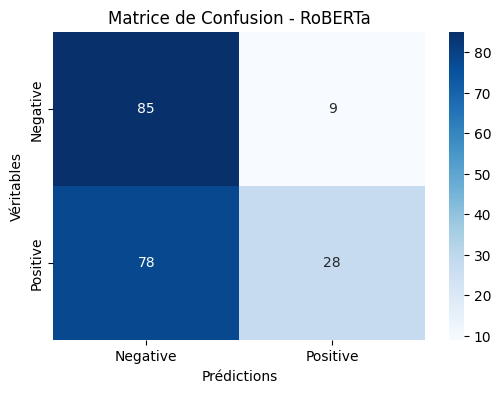

In [ ]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

# Charger RoBERTa et tokenizer
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Dataset personnalisé
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(self.labels[idx])
        return inputs

# Charger un échantillon de données
sample_size = 1000
df_sample = df.sample(sample_size, random_state=42)
texts = df_sample['text_stemmed'].tolist()
labels = df_sample['sentiment'].tolist()

# Diviser les données
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Préparer les datasets et DataLoaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Configurer l'optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Entraîner le modèle
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Époque {epoch + 1} - Perte moyenne : {total_loss / len(train_loader)}")

# Évaluer le modèle
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs['labels'].cpu().numpy())

# Calculer les métriques
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.title("Matrice de Confusion - RoBERTa")
plt.show()

##### test DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Device utilisé : cpu


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Époque 1 - Perte moyenne : 0.671787828207016
Époque 2 - Perte moyenne : 0.47112065434455874
Époque 3 - Perte moyenne : 0.22768786281347275
Accuracy: 0.7250
Precision: 0.7684
Recall: 0.6887
F1 Score: 0.7264


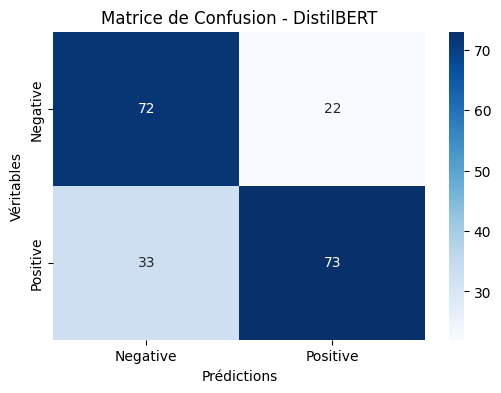

In [ ]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

# Charger DistilBERT et tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Dataset personnalisé
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(self.labels[idx])
        return inputs

# Charger un échantillon de données
sample_size = 1000
df_sample = df.sample(sample_size, random_state=42)
texts = df_sample['text_stemmed'].tolist()
labels = df_sample['sentiment'].tolist()

# Diviser les données
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Préparer les datasets et DataLoaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Configurer l'optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Entraîner le modèle
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Époque {epoch + 1} - Perte moyenne : {total_loss / len(train_loader)}")

# Évaluer le modèle
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs['labels'].cpu().numpy())

# Calculer les métriques
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.title("Matrice de Confusion - DistilBERT")
plt.show()